# Introduction

The used dataset is a subset of the Kaggle MNIST data on images of hand-written digits. 
There are images of four digits: 0, 1, 7, 8. Each digit image is 28*28 pixels scaled into [0,1] by dividing the Kaggle 
images by 255. 

The dataset contains columns of pixel features (28*28 columns) and a column of digit labels: 0, 1, 7, 8.
The original data are described here: http://yann.lecun.com/exdb/mnist/


* Line that needs changing so that anyone can run this notebook, is the filepath. Simply change to respective location

* Model specifications and computations for epistemic and aleatoric uncertainty follow code from this notebook https://colab.research.google.com/github/onefishy/am207_fall19_projects/blob/master/what_uncertainties/what_uncertainties_3/cheruvuria_136145_9127626_Final_Project_Submission.ipynb#scrollTo=Xro86iRBavG_


# Preparation

In [3]:
from __future__ import print_function

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import imshow
import tqdm
import matplotlib.gridspec as gridspec
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
import tensorflow_probability as tfp
distributions = tfp.distributions
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from itertools import product
from tensorflow.keras.regularizers import l2

PLEASE SPECIFY THE FILEPATH WHERE THIS WORK IS SAVED BELOW

In [4]:
filepath = '/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection'

Load data and construct train, val, test split

In [5]:
from sklearn.model_selection import train_test_split
def get_mnist_data(filepath=filepath):
    df_mnist = pd.read_csv(filepath + '/data/mnist.csv', index_col=[0])
    y_mnist_label = df_mnist["label"]
    X_mnist = df_mnist.iloc[:, 1:]

    random_state = 10

    (X_mnist_train_full, X_mnist_test, 
    y_mnist_train_full, y_mnist_test) = train_test_split(X_mnist, 
                                                        y_mnist_label,
                                                        test_size=0.2,
                                                        random_state=random_state)

    (X_mnist_train, X_mnist_val, 
    y_mnist_train, y_mnist_val) = train_test_split(X_mnist_train_full, 
                                                    y_mnist_train_full,
                                                    test_size=0.25,
                                                    random_state=random_state)

    return (df_mnist, y_mnist_label, X_mnist,
            X_mnist_test, y_mnist_test,
            X_mnist_train, y_mnist_train,
            X_mnist_val, y_mnist_val)



In [6]:
(df_mnist, y_mnist_label, X_mnist,
            X_mnist_test, y_mnist_test,
            X_mnist_train, y_mnist_train,
            X_mnist_val, y_mnist_val) = get_mnist_data()

# Data Exploration

size of data set

In [7]:
df_mnist.shape[0] 

17280

Note that this subset of the MNIST dataset only contains digits 0,1,7,8

In [8]:
y_mnist_label.unique()

array([1, 0, 7, 8])

## Balanced classes

[4132, 4684, 4401, 4063]


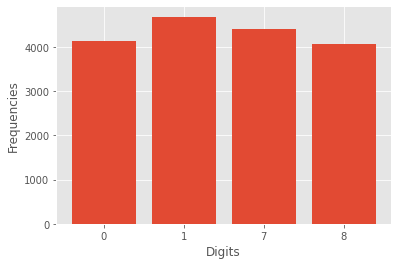

In [9]:
num_digits = []
for i in np.unique(y_mnist_label):
    num_digits.append(sum(y_mnist_label==i))
print(num_digits)

fig, ax = plt.subplots() 
# ax.bar(np.unique(y_mnist_label), num_digits)
ax.bar(np.arange(0, 4, 1), num_digits)
ax.set_xlabel("Digits")
ax.set_ylabel("Frequencies")
plt.xticks(np.arange(0,4,1), np.unique(y_mnist_label))
plt.show()

## TSNE

See [this section](#cell-id) at the end of the notebook, where TSNE is used to visualize LOF outliers as well as samples with highest uncertainties. Below, is a scatter function (based on code from DME labs) to visualise TSNE embeddings.

In [10]:
import seaborn as sns
def scatter_2d_label_LOF(X_2d, y, X_scores, uncertainty, descr,
                         ax=None, s=2, alpha=0.5, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    X_scores : scores from LOF fit_predict
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, label=target, s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='Outlier scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=10,
               label=descr)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, 
              frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [172]:
def scatter_2d_label_LOF_with_highest(X_2d, y, X_scores, uncertainty, 
                                      highest_uncertainty, descr, 
                                      descr_2, ax=None, s=2, alpha=0.5, lw=2):
    """
    2nd version of scatter plot to highlight sample with highest uncertainty
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, 
                   label="Digit " + str((target)), 
                   s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='LOF scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=25,
               label=descr)
    ax.scatter(X_2d[highest_uncertainty, 0], X_2d[highest_uncertainty, 1], 
               color="fuchsia", s=300, label=descr_2)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    # add legend
    #ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], 
              #scatterpoints=1, frameon=False); # Add a legend outside the plot at specified point
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', #bbox_transform=fig.transFigure,
               frameon=False, ncol=5, prop={"size":15}, markerscale=1.5)
    
    return ax


## Reshaping labels

Next, reshape the images to 28x28 pixels and transform labels into one-hot encoded categories

In [12]:
X_mnist = X_mnist.values.reshape(-1,28,28,1)
X_mnist_test = X_mnist_test.values.reshape(-1,28,28,1)
X_mnist_train = X_mnist_train.values.reshape(-1,28,28,1)
X_mnist_val = X_mnist_val.values.reshape(-1,28,28,1)

# keeping original labels
# converting labels into one-hot encoding
# [1,0,0,0]=class 0
# [0,1,0,0]=class 1
# [0,0,1,0]=class 7
# [0,0,0,1]=class 8

y_mnist_label_original = y_mnist_label
y_mnist_label = tf.keras.utils.to_categorical(y_mnist_label, num_classes=10)
y_mnist_label = y_mnist_label[:,[0,1,7,8]]

y_mnist_test_original = y_mnist_test
y_mnist_test = tf.keras.utils.to_categorical(y_mnist_test, num_classes=10)
y_mnist_test = y_mnist_test[:,[0,1,7,8]]

y_mnist_train_original = y_mnist_train
y_mnist_train = tf.keras.utils.to_categorical(y_mnist_train, num_classes=10)
y_mnist_train = y_mnist_train[:,[0,1,7,8]]

y_mnist_val_original = y_mnist_val
y_mnist_val = tf.keras.utils.to_categorical(y_mnist_val, num_classes=10)
y_mnist_val = y_mnist_val[:,[0,1,7,8]]

In [13]:
# so that's how the labels look like now
y_mnist_label

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

quick check that all shapes are as expected

In [14]:
print(f"shape of X_mist: {X_mnist.shape}")
print(f"shape of y_mnist_label: {y_mnist_label.shape}")

print(f"shape of X_mnist_test: {X_mnist_test.shape}")
print(f"shape of y_mnist_test: {y_mnist_test.shape}")

print(f"shape of X_mnist_val: {X_mnist_val.shape}")
print(f"shape of y_mnist_val: {y_mnist_val.shape}")

print(f"shape of X_mnist_train: {X_mnist_train.shape}")
print(f"shape of y_mnist_train: {y_mnist_train.shape}")



shape of X_mist: (17280, 28, 28, 1)
shape of y_mnist_label: (17280, 4)
shape of X_mnist_test: (3456, 28, 28, 1)
shape of y_mnist_test: (3456, 4)
shape of X_mnist_val: (3456, 28, 28, 1)
shape of y_mnist_val: (3456, 4)
shape of X_mnist_train: (10368, 28, 28, 1)
shape of y_mnist_train: (10368, 4)


# Correct Class Converter

two helper functions which give correct class number given its one-hot encoding or given class label as 0,1,2,3 rather than 0,1,7,8

In [15]:
def correct_class(sample_idx, y_label):
    class_label = np.argmax(y_label[sample_idx])
    if class_label == 2:
        class_label = 7
    if class_label == 3:
        class_label = 8
    return class_label

def class_converter(idx):
    if idx == 0:
        res = 0
    if idx == 1:
        res = 1
    if idx == 2:
        res = 7
    if idx == 3:
        res = 8
    return res

In [16]:
# example of how function works
idx = 123
print(correct_class(idx, y_mnist_val))
print(y_mnist_val[idx])
print(class_converter(2))

7
[0. 0. 1. 0.]
7


# Save function

Function which allows to save trained models

In [17]:
"""def save_model(model, batch_size, n_epochs, descr, learning_rate, dropout=None):
    fp_first = '/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models'
    fp0 = "/model_" + descr
    fp1 = "_batchsize" + str(batch_size)
    fp2 = "_nepoch" + str(n_epochs)
    if dropout == None:
        fp3 = ""
    else:
        fp3 = '_dropout' + str(dropout*100)
    fp4 = '_learningrate' + str(learning_rate*1000)
    fp_last = ".h5"

    fp_full = fp_first + fp0 + fp1 + fp2 + fp3 + fp4 + fp_last

    model.save(fp_full)"""

'def save_model(model, batch_size, n_epochs, descr, learning_rate, dropout=None):\n    fp_first = \'/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models\'\n    fp0 = "/model_" + descr\n    fp1 = "_batchsize" + str(batch_size)\n    fp2 = "_nepoch" + str(n_epochs)\n    if dropout == None:\n        fp3 = ""\n    else:\n        fp3 = \'_dropout\' + str(dropout*100)\n    fp4 = \'_learningrate\' + str(learning_rate*1000)\n    fp_last = ".h5"\n\n    fp_full = fp_first + fp0 + fp1 + fp2 + fp3 + fp4 + fp_last\n\n    model.save(fp_full)'

# Loss function

Most important part here is ```bayesian_categorical_crossentropy``` as this is the loss function necessary to capture aleatoric uncertainty and allows for loss attenuation

In [18]:
def softmax(pred):
  return K.exp(pred - K.log(K.sum(K.exp(pred))))  # numerically stable softmax
  
def softmax_np(pred):
  return np.exp(pred - np.log(np.sum(np.exp(pred), axis=1)).reshape(pred.shape[0],1))  

def gaussian_softmax(ypred, dist, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    # distorted_loss = softmax(ypred + std_samples)
    distorted_loss = tf.keras.activations.softmax(ypred + std_samples, axis=-1)
    return distorted_loss
  return map_fn

# aleatoric loss function 
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])[0] # add this 
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std+1e-6)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')
    variance_loss = K.categorical_crossentropy(ytrue, K.mean(monte_carlo_results, axis=0))
    
    return variance_loss 

  return bayesian_categorical_crossentropy_internal

# Loss and accuracy plot function

Function to visualize loss and accuracy during a training run

In [19]:
def loss_accuracy_plot(fit_history):
  # Plot training & validation accuracy values
  plt.plot(fit_history.history['accuracy'])
  plt.plot(fit_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# Confusion matrix function

In [20]:
# function from DME labs
import seaborn as sns

def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt = '.2f'
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Functions to calcuclate epistemic and aleatoric uncertainties

### Epistemic uncertainty

In [21]:
# making 100 predictions for each sample of val/test set for each class
import tqdm
def make_predictions(model, n_pred=100, batch_size=100, val_data=X_mnist_test):
  predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      y_p = model.predict(val_data, batch_size=batch_size)
      predictions.append(y_p)
  return predictions

In [22]:
# calculate mean predictions, std, and epistemic uncertainty
def cal_epistemic(predictions):
  p = np.array(predictions)
  y_mean = p.mean(axis=0) # prediction mean of 100 predictions
  w = 1/np.sum(y_mean, axis=1).reshape(y_mean.shape[0],1)
  y_mean = (y_mean*w)
  y_std = p.std(axis=0, ddof=1)*w

  epi_1 = y_std.max(axis=1)
  epi_2 = y_std.mean(axis=1)
  epi_3 = -(p.mean(axis=0) * np.log(p.mean(axis=0))).sum(axis=1)
  return y_mean, y_std, [epi_1, epi_2, epi_3]

In [23]:
# calculate mean ensemble prediction and accuracy
# note, no need to change to actual labels 0,1,7,8
def ensemble_pred(predictions, val_data=y_mnist_test):
  ensemble_pred = np.array(predictions).mean(axis=0).argmax(axis=1) # max mean pred
  ensemble_acc = accuracy_score(val_data.argmax(axis=1), ensemble_pred)
  print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))
  return ensemble_pred, ensemble_acc

In [24]:
# Functions to print out the n images with highest/lowest uncertainties
def show_epistemic(epi, prediction, highest=True, n_epi=20,
                   x_data=X_mnist_test, y_data=y_mnist_test):
  if highest == True:
    epi_idx = epi.argsort()[::-1]
  if highest == False:
    epi_idx = epi.argsort()
  for idx in epi_idx[:n_epi]:
    plt.imshow(x_data[idx, :, :, 0], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, correct_class(idx, y_data), axis=-1))
    print(f"Predicted label of test sample {idx}: {class_converter(prediction[idx])}")
    print(f"Epistemic uncertainty: {epi[idx]:.4}")
    plt.show()

### Aleatoric uncertainty

In [25]:
# function to calculate aleatoric uncertainty from outputed sigmas
def cal_aleatoric(model, test_data=X_mnist_test):
  output_alea = model(test_data)
  # predicted_classes = np.argmax(output_alea[:,:4], axis=-1)
  predicted_classes = np.argmax(tf.keras.activations.softmax(output_alea[:,:4]).numpy(), 
                                axis=-1)
  sigmas = np.exp(output_alea[:,4])
  return predicted_classes, sigmas

# function to plot n images with highest/lowest aleatoric uncertanty
def show_aleatoric(sigmas, prediction, highest=True, n_alea=20,
                   x_data=X_mnist_test, y_data=y_mnist_test):
    if highest == True:
      alea_idx = sigmas.argsort()[::-1]
    if highest == False:
      alea_idx = sigmas.argsort()
    for idx in alea_idx[:n_alea]:
      plt.imshow(x_data[idx, :, :, 0], cmap='gist_gray')
      print(f"True label of the test sample {idx}: {correct_class(idx, y_data)}")
      print(f"Predicted label of test sample {idx}: {class_converter(prediction[idx])}")
      print(f"Aleatoric uncertainty: {sigmas[idx]:.4}")
      plt.show()

# MODEL SPECIFICATION - CONVOLUTIONAL

The model specification is such that ```model_creator``` corresponds to 

* the baseline, if ```dropout_prob=0.0``` and ```include_logvar=False```

* the model for epistemic uncertainty, if ```dropout_prob!=0.0``` and ```include_logvar=False```

* the model for aleatoric uncertainty, if ```dropout_prob=0.0``` and ```include_logvar=True```

* the model for aleatoric & epistemic uncertainty, if ```dropout_prob!=0.0``` and ```include_logvar=True```

In [26]:
def model_creator(act="relu", dropout_prob=0.25, 
                  loss=keras.losses.categorical_crossentropy, 
                  include_logvar=False,
                  learning_rate=0.001):
  """
  Create CNN model using Keras Functional API.
  Architecture taken from https://keras.io/examples/cifar10_cnn/ and modified
  """
  input_shape = (28, 28, 1)
  N =  input_shape[0]*input_shape[1]

  # L2 regularisation if dropout is employed to avoid predicting infinite
  # uncertainties
  reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0  

  inputs = Input(shape=input_shape)
  inter = Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=l2(reg))(inputs)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True)
  inter = Conv2D(64, (3, 3), kernel_regularizer=l2(reg))(inter)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True) # BEFORE maxpooling
  inter = MaxPooling2D(pool_size=(2, 2))(inter)
  
  inter = Flatten()(inter)
  inter = Dense(256, kernel_regularizer=l2(reg))(inter)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True)

  if include_logvar:
      # include variance and output logits rather than softmax
      outputs = Dense(num_classes+1, activation=None, kernel_regularizer=l2(reg))(inter) 
  else:
     outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg))(inter) 
  
  model = Model(inputs, outputs)
  metrics = ['accuracy']
  model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=metrics,
                  run_eagerly=True)
  return model

## Original model with NO dropout and NO log(sigma)

### Hyperparameter tuning

In [27]:
"""def model_creator(filter, unit, act="relu", dropout_prob=0.25, 
                  loss=keras.losses.categorical_crossentropy, 
                  include_logvar=False,
                  learning_rate=0.001):

  Create CNN model using Keras Functional API.
  Architecture taken from https://keras.io/examples/cifar10_cnn/ and modified
"""
"""
  input_shape = (28, 28, 1)
  N =  input_shape[0]*input_shape[1]

  # L2 regularisation if dropout is employed to avoid predicting infinite
  # uncertainties
  reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0  

  inputs = Input(shape=input_shape)
  inter = Conv2D(filter[0], (3, 3), padding='same',
                  kernel_regularizer=l2(reg))(inputs)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True)
  inter = Conv2D(filter[1], (3, 3), kernel_regularizer=l2(reg))(inter)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True) # BEFORE maxpooling
  inter = MaxPooling2D(pool_size=(2, 2))(inter)
  
  inter = Flatten()(inter)
  inter = Dense(unit[0], kernel_regularizer=l2(reg))(inter)
  inter = Activation('relu')(inter)
  inter = Dropout(dropout_prob)(inter, training=True)

  if include_logvar:
      # include variance and output logits rather than softmax
      outputs = Dense(num_classes+1, activation=None, kernel_regularizer=l2(reg))(inter) 
  else:
     outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg))(inter) 
  
  model = Model(inputs, outputs)
  metrics = ['accuracy']
  model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=metrics,
                  run_eagerly=True)
  return model"""

"\n  input_shape = (28, 28, 1)\n  N =  input_shape[0]*input_shape[1]\n\n  # L2 regularisation if dropout is employed to avoid predicting infinite\n  # uncertainties\n  reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0  \n\n  inputs = Input(shape=input_shape)\n  inter = Conv2D(filter[0], (3, 3), padding='same',\n                  kernel_regularizer=l2(reg))(inputs)\n  inter = Activation('relu')(inter)\n  inter = Dropout(dropout_prob)(inter, training=True)\n  inter = Conv2D(filter[1], (3, 3), kernel_regularizer=l2(reg))(inter)\n  inter = Activation('relu')(inter)\n  inter = Dropout(dropout_prob)(inter, training=True) # BEFORE maxpooling\n  inter = MaxPooling2D(pool_size=(2, 2))(inter)\n  \n  inter = Flatten()(inter)\n  inter = Dense(unit[0], kernel_regularizer=l2(reg))(inter)\n  inter = Activation('relu')(inter)\n  inter = Dropout(dropout_prob)(inter, training=True)\n\n  if include_logvar:\n      # include variance and output logits rather than softmax\n      outputs = Dense

In [28]:
"""num_classes = 4
input_shape = (28, 28, 1)

epochs = 20
dropout_p = 0.0


batch_sizes = [64, 128, 256]
learning_rates = [0.01, 0.001]
filters = [[64, 64], [128, 128]]
units = [[128], [256]]"""


'num_classes = 4\ninput_shape = (28, 28, 1)\n\nepochs = 20\ndropout_p = 0.0\n\n\nbatch_sizes = [64, 128, 256]\nlearning_rates = [0.01, 0.001]\nfilters = [[64, 64], [128, 128]]\nunits = [[128], [256]]'

In [29]:
"""for i, (batch_size, learning_rate, filter, unit) in enumerate(product(batch_sizes, learning_rates, filters, units)):
  print(f"{filter} filter, {unit} unit, {batch_size} batch_size, {learning_rate} learning_rate")

  orig_mnist_model_cnn = model_creator(filter=filter, unit=unit,
                                       act="relu", dropout_prob=dropout_p,
                                       learning_rate=learning_rate)
  
  orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, 
                                            validation_data=(X_mnist_val, y_mnist_val), 
                                            batch_size=batch_size, epochs=epochs, verbose=1)
  
  loss_accuracy_plot(orig_history_cnn)
  
  descr = "f_" + str(filter[0]) + str (filter[1])
  descr = descr + "u_" + str(unit[0])

  save_model(model=orig_mnist_model_cnn, batch_size=batch_size, 
             n_epochs=epochs, descr="hyptune_cnnmodel" + descr, 
             learning_rate=learning_rate)
  print(f"done with {i}th training loop\n")"""


'for i, (batch_size, learning_rate, filter, unit) in enumerate(product(batch_sizes, learning_rates, filters, units)):\n  print(f"{filter} filter, {unit} unit, {batch_size} batch_size, {learning_rate} learning_rate")\n\n  orig_mnist_model_cnn = model_creator(filter=filter, unit=unit,\n                                       act="relu", dropout_prob=dropout_p,\n                                       learning_rate=learning_rate)\n  \n  orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, \n                                            validation_data=(X_mnist_val, y_mnist_val), \n                                            batch_size=batch_size, epochs=epochs, verbose=1)\n  \n  loss_accuracy_plot(orig_history_cnn)\n  \n  descr = "f_" + str(filter[0]) + str (filter[1])\n  descr = descr + "u_" + str(unit[0])\n\n  save_model(model=orig_mnist_model_cnn, batch_size=batch_size, \n             n_epochs=epochs, descr="hyptune_cnnmodel" + descr, \n             learning_rate=learn

### Chosen Hyperparameters

Chosen architecture: ```[64, 64] filter, [256] unit, 256 batch_size, 0.01 learning_rate```

In [30]:
num_classes = 4
input_shape = (28, 28, 1)

epochs = 20
batch_size = 256
dropout_p = 0.0
learning_rate = 0.01

### Model fitting

In [31]:
"""orig_mnist_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,
                                     learning_rate=learning_rate)
orig_mnist_model_cnn.summary()"""

'orig_mnist_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,\n                                     learning_rate=learning_rate)\norig_mnist_model_cnn.summary()'

In [32]:
"""orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, 
                                            validation_data=(X_mnist_test, y_mnist_test), 
                                            batch_size=batch_size, epochs=epochs, verbose=1)"""


'orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, \n                                            validation_data=(X_mnist_test, y_mnist_test), \n                                            batch_size=batch_size, epochs=epochs, verbose=1)'

In [33]:
"""save_model(model=orig_mnist_model_cnn, batch_size=batch_size, 
           n_epochs=epochs, descr="orig_mnist_model_cnn", 
           learning_rate=learning_rate,
           dropout=None)"""

'save_model(model=orig_mnist_model_cnn, batch_size=batch_size, \n           n_epochs=epochs, descr="orig_mnist_model_cnn", \n           learning_rate=learning_rate,\n           dropout=None)'

In [34]:
orig_mnist_model_cnn = tf.keras.models.load_model(filepath + "/FINAL_trained_models/model_orig_mnist_model_cnn_batchsize256_nepoch20_learningrate10.0.h5")

In [35]:
"""loss_accuracy_plot(orig_history_cnn)"""

'loss_accuracy_plot(orig_history_cnn)'

In [36]:
"""loss_orig_eval_cnn, accuracy_orig_eval_cnn = orig_mnist_model_cnn.evaluate(X_mnist_test, 
                                                                           y_mnist_test, 
                                                                           verbose=0)"""

'loss_orig_eval_cnn, accuracy_orig_eval_cnn = orig_mnist_model_cnn.evaluate(X_mnist_test, \n                                                                           y_mnist_test, \n                                                                           verbose=0)'

In [37]:
"""print(f"Eval loss = {loss_orig_eval_cnn}, Eval accuracy = {accuracy_orig_eval_cnn}")"""

'print(f"Eval loss = {loss_orig_eval_cnn}, Eval accuracy = {accuracy_orig_eval_cnn}")'

### Confusion matrix

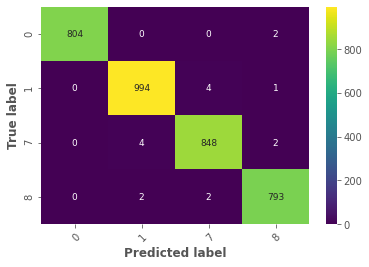

In [38]:
pred = np.argmax(orig_mnist_model_cnn(X_mnist_test), axis=1)
conveted_pred = [class_converter(i) for i in pred]
conf = confusion_matrix(y_mnist_test_original, conveted_pred)
plot_confusion_matrix(conf, [0,1,7,8])

## EPISTEMIC (MC model)

### Hyperparameter tuning for dropout

In [39]:
"""num_classes = 4
input_shape = (28, 28, 1)

epochs = 20
batch_size = 256
learning_rate = 0.01

dropout_ps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]"""

'num_classes = 4\ninput_shape = (28, 28, 1)\n\nepochs = 20\nbatch_size = 256\nlearning_rate = 0.01\n\ndropout_ps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]'

In [40]:
"""for i, (dropout_p) in enumerate(dropout_ps):
  print(f"{dropout_p} dropout_p")

  orig_mnist_model_cnn = model_creator(act="relu", dropout_prob=dropout_p, 
                                       learning_rate=0.01)
  
  orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, 
                                            validation_data=(X_mnist_val, y_mnist_val), 
                                            batch_size=256, epochs=20, verbose=1)
  
  loss_accuracy_plot(orig_history_cnn)
  

  save_model(model=orig_mnist_model_cnn, batch_size=256, 
             n_epochs=20, descr="hyptune_dropout_cnnmodel", 
             learning_rate=0.01)
  print(f"done with {i}th training loop\n")"""


'for i, (dropout_p) in enumerate(dropout_ps):\n  print(f"{dropout_p} dropout_p")\n\n  orig_mnist_model_cnn = model_creator(act="relu", dropout_prob=dropout_p, \n                                       learning_rate=0.01)\n  \n  orig_history_cnn = orig_mnist_model_cnn.fit(X_mnist_train, y_mnist_train, \n                                            validation_data=(X_mnist_val, y_mnist_val), \n                                            batch_size=256, epochs=20, verbose=1)\n  \n  loss_accuracy_plot(orig_history_cnn)\n  \n\n  save_model(model=orig_mnist_model_cnn, batch_size=256, \n             n_epochs=20, descr="hyptune_dropout_cnnmodel", \n             learning_rate=0.01)\n  print(f"done with {i}th training loop\n")'

### Hyperparameters with chosen dropout probability

Chosen dropout probability ```dropout_p = 0.25```


In [41]:
num_classes = 4
input_shape = (28, 28, 1)

epochs = 20
batch_size = 256
learning_rate = 0.01

dropout_p = 0.25 

### Model fitting

In [42]:
"""mc_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,
                             learning_rate=learning_rate)"""

'mc_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,\n                             learning_rate=learning_rate)'

In [43]:
"""mc_history_cnn = mc_model_cnn.fit(X_mnist_train, y_mnist_train, 
                                    validation_data=(X_mnist_test, y_mnist_test), 
                                    batch_size=batch_size, epochs=epochs, verbose=1)"""

'mc_history_cnn = mc_model_cnn.fit(X_mnist_train, y_mnist_train, \n                                    validation_data=(X_mnist_test, y_mnist_test), \n                                    batch_size=batch_size, epochs=epochs, verbose=1)'

In [44]:
"""save_model(model=mc_model_cnn, batch_size=batch_size, 
           n_epochs=epochs, descr="mc_model_mnist_cnn", 
           dropout=dropout_p, learning_rate=learning_rate)"""

'save_model(model=mc_model_cnn, batch_size=batch_size, \n           n_epochs=epochs, descr="mc_model_mnist_cnn", \n           dropout=dropout_p, learning_rate=learning_rate)'

In [45]:
"""loss_accuracy_plot(mc_history_cnn)"""

'loss_accuracy_plot(mc_history_cnn)'

In [46]:
mc_model_cnn = tf.keras.models.load_model(filepath + "/FINAL_trained_models/model_mc_model_mnist_cnn_batchsize256_nepoch20_dropout25.0_learningrate10.0.h5",
                                          # custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy}
                                          )



In [47]:
"""loss_mc_eval_cnn, accuracy_mc_eval_cnn = mc_model_cnn.evaluate(X_mnist_test, y_mnist_test, verbose=0)
print(f"Eval loss = {loss_mc_eval_cnn}, Eval accuracy = {accuracy_mc_eval_cnn}")"""

'loss_mc_eval_cnn, accuracy_mc_eval_cnn = mc_model_cnn.evaluate(X_mnist_test, y_mnist_test, verbose=0)\nprint(f"Eval loss = {loss_mc_eval_cnn}, Eval accuracy = {accuracy_mc_eval_cnn}")'

### Examples

In [48]:
mc_cnn_predictions = make_predictions(mc_model_cnn)
mc_cnn_ensemble_pred, mc_cnn_ensemble_acc = ensemble_pred(mc_cnn_predictions)
mc_cnn_y_mean, mc_cnn_y_std, mc_cnn_epistemic = cal_epistemic(mc_cnn_predictions)

100%|██████████| 100/100 [00:16<00:00,  5.90it/s]

MC-ensemble accuracy: 99.4%


In [49]:
from numpy import loadtxt
fp = filepath + "/TEST_saved_uncertainties"
mc_cnn_epistemic = loadtxt(fp+'/mc_epistemic_mnist.csv', delimiter=',')
mc_cnn_y_mean = loadtxt(fp+'/mc_y_mean_mnist.csv', delimiter=',')
mc_cnn_ensemble_pred = loadtxt(fp+'/mc_ensemble_pred_mnist.csv', delimiter=',')

In [50]:
"""from numpy import savetxt
fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/mc_epistemic_mnist.csv', mc_cnn_epistemic, delimiter=',')
savetxt(fp + '/mc_y_mean_mnist.csv', mc_cnn_y_mean, delimiter=',')
savetxt(fp + '/mc_ensemble_pred_mnist.csv', mc_cnn_ensemble_pred, delimiter=',')"""

'from numpy import savetxt\nfp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/mc_epistemic_mnist.csv\', mc_cnn_epistemic, delimiter=\',\')\nsavetxt(fp + \'/mc_y_mean_mnist.csv\', mc_cnn_y_mean, delimiter=\',\')\nsavetxt(fp + \'/mc_ensemble_pred_mnist.csv\', mc_cnn_ensemble_pred, delimiter=\',\')'

#### Confusion matrix

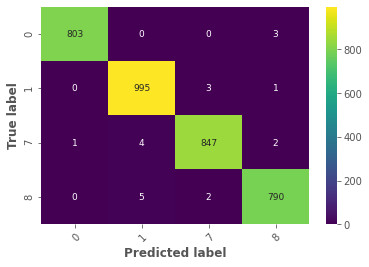

In [51]:
pred = np.argmax(mc_cnn_y_mean, axis=1)
converted_pred = [class_converter(i) for i in pred]
conf = confusion_matrix(y_mnist_test_original, converted_pred)
plot_confusion_matrix(conf, [0,1,7,8])

#### Epistemic part 1

In [52]:
#show_epistemic(mc_cnn_epistemic[0], mc_cnn_ensemble_pred)

In [53]:
#show_epistemic(mc_cnn_epistemic[0], mc_cnn_ensemble_pred, highest=False)

#### Epistemic part 2

In [54]:
#show_epistemic(mc_cnn_epistemic[1], mc_cnn_ensemble_pred)

In [55]:
#show_epistemic(mc_cnn_epistemic[1], mc_cnn_ensemble_pred, highest=False)

#### Epistemic part 3

In [ ]:
show_epistemic(mc_cnn_epistemic[2], mc_cnn_ensemble_pred)

In [ ]:
show_epistemic(mc_cnn_epistemic[2], mc_cnn_ensemble_pred, highest=False)

#### Comparing epistemic

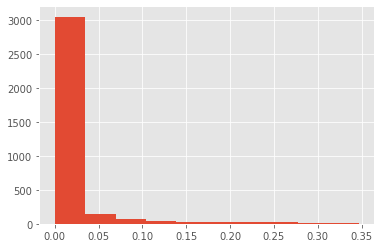

In [58]:
plt.hist(mc_cnn_epistemic[0])
plt.show()

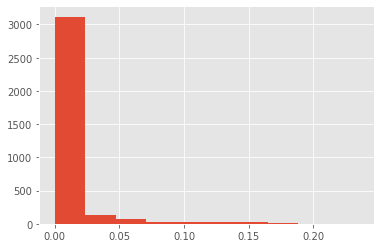

In [59]:
plt.hist(mc_cnn_epistemic[1])
plt.show()

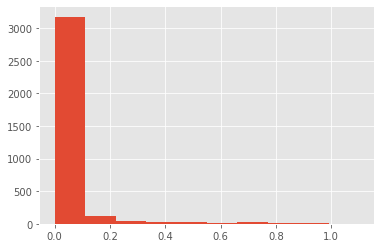

In [60]:
plt.hist(mc_cnn_epistemic[2])
plt.show()

## ALEATORIC

### Hyperparameters

In [61]:
num_classes = 4
input_shape = (28, 28, 1)
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

epochs = 20
batch_size = 256
dropout_p = 0.0
learning_rate = 0.01
dropout_p = 0.0

### Model fitting

In [62]:
"""alea_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,
                             learning_rate=learning_rate,
                             include_logvar=True, loss=loss_fn)
alea_model_cnn.summary()"""

'alea_model_cnn = model_creator(act="relu", dropout_prob=dropout_p,\n                             learning_rate=learning_rate,\n                             include_logvar=True, loss=loss_fn)\nalea_model_cnn.summary()'

In [63]:
"""alea_cnn_history = alea_model_cnn.fit(X_mnist_train, y_mnist_train, 
                               validation_data=(X_mnist_test, y_mnist_test),
                              batch_size=batch_size, epochs=epochs, verbose=1)"""

'alea_cnn_history = alea_model_cnn.fit(X_mnist_train, y_mnist_train, \n                               validation_data=(X_mnist_test, y_mnist_test),\n                              batch_size=batch_size, epochs=epochs, verbose=1)'

In [64]:
"""save_model(model=alea_model_cnn, batch_size=batch_size, 
           n_epochs=epochs, descr="alea_model_mnist", 
           dropout=None, learning_rate=learning_rate)"""

'save_model(model=alea_model_cnn, batch_size=batch_size, \n           n_epochs=epochs, descr="alea_model_mnist", \n           dropout=None, learning_rate=learning_rate)'

In [65]:
alea_model_cnn = tf.keras.models.load_model(filepath + "/FINAL_trained_models/model_alea_model_mnist_batchsize256_nepoch20_learningrate10.0.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [66]:
"""loss_accuracy_plot(alea_cnn_history)"""

'loss_accuracy_plot(alea_cnn_history)'

In [67]:
"""loss_alea_cnn_eval, accuracy_alea_cnn_eval = alea_model_cnn.evaluate(X_mnist_test, y_mnist_test, verbose=0)
print(f"Eval loss = {loss_alea_cnn_eval}, Eval accuracy = {accuracy_alea_cnn_eval}")"""

'loss_alea_cnn_eval, accuracy_alea_cnn_eval = alea_model_cnn.evaluate(X_mnist_test, y_mnist_test, verbose=0)\nprint(f"Eval loss = {loss_alea_cnn_eval}, Eval accuracy = {accuracy_alea_cnn_eval}")'

### Examples

In [68]:
pred_class_alea_cnn, sigmas_alea_cnn = cal_aleatoric(alea_model_cnn)

In [69]:
fp = filepath + "/TEST_saved_uncertainties"
sigmas_alea_cnn = loadtxt(fp+'/alea_mnist.csv', delimiter=',')
pred_class_alea_cnn = loadtxt(fp+'/pred_class_alea_mnist.csv', delimiter=',')

In [70]:
"""fp = /TEST_saved_uncertainties"
savetxt(fp + '/alea_mnist.csv', sigmas_alea_cnn, delimiter=',')
savetxt(fp + '/pred_class_alea_mnist.csv', pred_class_alea_cnn, delimiter=',')"""

'fp = /TEST_saved_uncertainties"\nsavetxt(fp + \'/alea_mnist.csv\', sigmas_alea_cnn, delimiter=\',\')\nsavetxt(fp + \'/pred_class_alea_mnist.csv\', pred_class_alea_cnn, delimiter=\',\')'

In [ ]:
show_aleatoric(sigmas_alea_cnn, pred_class_alea_cnn)

In [ ]:
show_aleatoric(sigmas_alea_cnn, pred_class_alea_cnn, highest=False)

<function matplotlib.pyplot.show>

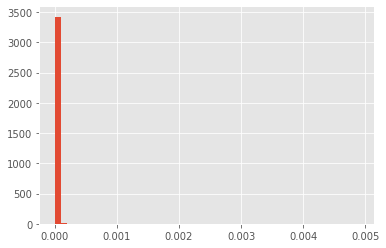

In [73]:
plt.hist(sigmas_alea_cnn, bins=50)
plt.show

### Confusion matrix

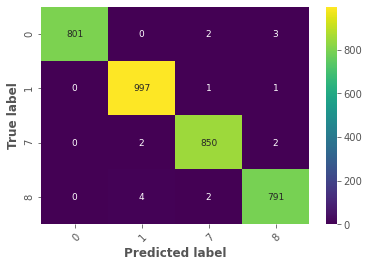

In [74]:
converted_pred = [class_converter(i) for i in pred_class_alea_cnn]
conf = confusion_matrix(y_mnist_test_original, converted_pred)
plot_confusion_matrix(conf, [0,1,7,8])

### Loss attenuation?

Gal et al. argue that with the provided loss function, the loss for wrongly classified samples is attenuated by giving these predictions high aleatoric uncertainties 

How many wrongly classified images are among the n predictions with highest aleatoric uncertainty?



In [75]:
def loss_att_check(sigmas, predicted_class, highest=True, n_alea=20,
                   x_data=X_mnist_test):
  #fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  if highest == True:
    alea_idx = sigmas.argsort()[::-1]
  if highest == False:
    alea_idx = sigmas.argsort()
  # only consider n top aleatoric indices 
  alea_idx = alea_idx[:n_alea]
  # convert predicted 0,1,2,3 to 0,1,7,8
  converted_pred = np.array([class_converter(i) for i in predicted_class])
  # number and idx of missclassified
  n_wrongclass_highalea = sum(converted_pred[alea_idx] != np.array(y_mnist_test_original)[alea_idx])
  wrongclass_highalea_idx = np.where(converted_pred[alea_idx] != np.array(y_mnist_test_original)[alea_idx])[0]
  # true and predicted labsl of missclassified
  pred_label = (converted_pred[alea_idx])[wrongclass_highalea_idx]
  true_label = (np.array(y_mnist_test_original)[alea_idx])[wrongclass_highalea_idx]
  return n_wrongclass_highalea, alea_idx[wrongclass_highalea_idx], true_label, pred_label

In [76]:
converted_pred = np.array([class_converter(i) for i in pred_class_alea_cnn])
print("number of misclassified samples: ", 
      sum(converted_pred != np.array(y_mnist_test_original)))

number of misclassified samples:  17


In [77]:
(n_wrongclass_highalea, alea_idx, 
 true_label, pred_label) = loss_att_check(sigmas_alea_cnn, pred_class_alea_cnn,
                           n_alea=1728) #n_alea=2953)

print(n_wrongclass_highalea, alea_idx, true_label, pred_label)

7 [2868 1331 1176  722  524  278 2365] [0 0 7 8 8 0 7] [7 7 8 7 7 8 8]


In [78]:
n_wrongclass_highalea / (sum(converted_pred != np.array(y_mnist_test_original)))

0.4117647058823529

In [79]:
sigmas_alea_cnn.shape[0]*0.5

1728.0

in the predictions with the lowest 15% (503/3456) of aleatoric uncertainties, no missclassification appears. In the 15% of highest aleatoric predictions, 45% of all missclassification (9/503) are found

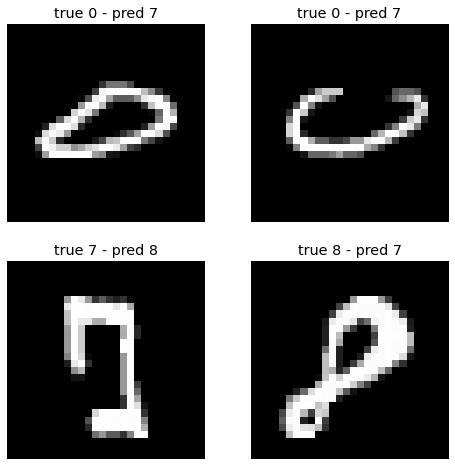

In [80]:
# plot the missclassified images among the 503 highest aleatoric uncertainty predictions
fig, axs = plt.subplots(2, 2, figsize=(8,8)) 
for idx, ax, true, pred in zip(alea_idx, axs.reshape(-1), true_label, pred_label):
    ax.imshow(X_mnist_test[idx, :, :, 0], cmap='gist_gray')
    ax.axis('off')
    ax.title.set_text(f'true {true} - pred {pred}')
  #fig.suptitle("Main Title")
plt.show()

## EPISTEMIC & ALEATORIC

### Hyperparameters

In [81]:
num_classes = 4
input_shape = (28, 28, 1)
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

epochs = 20
batch_size = 256
dropout_p = 0.0
learning_rate = 0.01
dropout_p = 0.25

### Model fitting

In [82]:
"""total_mc_cnn_model = model_creator(act="relu", dropout_prob=dropout_p, 
                           loss=loss_fn, include_logvar=True,
                           learning_rate=learning_rate)
total_mc_cnn_model.summary()"""

'total_mc_cnn_model = model_creator(act="relu", dropout_prob=dropout_p, \n                           loss=loss_fn, include_logvar=True,\n                           learning_rate=learning_rate)\ntotal_mc_cnn_model.summary()'

In [83]:
"""total_mc_cnn_history = total_mc_cnn_model.fit(X_mnist_train, y_mnist_train, 
                               validation_data=(X_mnist_test, y_mnist_test),
                              batch_size=batch_size, epochs=epochs, verbose=1)"""

'total_mc_cnn_history = total_mc_cnn_model.fit(X_mnist_train, y_mnist_train, \n                               validation_data=(X_mnist_test, y_mnist_test),\n                              batch_size=batch_size, epochs=epochs, verbose=1)'

In [84]:
"""save_model(model=total_mc_cnn_model, batch_size=batch_size, 
           n_epochs=epochs, descr="total_mc_model_mnist",
           learning_rate=learning_rate, 
           dropout=dropout_p)"""

'save_model(model=total_mc_cnn_model, batch_size=batch_size, \n           n_epochs=epochs, descr="total_mc_model_mnist",\n           learning_rate=learning_rate, \n           dropout=dropout_p)'

In [85]:
"""loss_accuracy_plot(total_mc_cnn_history)"""

'loss_accuracy_plot(total_mc_cnn_history)'

In [86]:
total_mc_cnn_model = tf.keras.models.load_model(filepath + "/FINAL_trained_models/model_total_mc_model_mnist_batchsize256_nepoch20_dropout25.0_learningrate10.0.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [87]:
"""loss_mc_total_cnn_eval, accuracy_mc_total_cnn_eval = total_mc_cnn_model.evaluate(X_mnist_test, y_mnist_test, verbose=0)
print(f"Eval loss = {loss_mc_total_cnn_eval}, Eval accuracy = {accuracy_mc_total_cnn_eval}")"""

'loss_mc_total_cnn_eval, accuracy_mc_total_cnn_eval = total_mc_cnn_model.evaluate(X_mnist_test, y_mnist_test, verbose=0)\nprint(f"Eval loss = {loss_mc_total_cnn_eval}, Eval accuracy = {accuracy_mc_total_cnn_eval}")'

#### Save all accuracies and losses so far

In [88]:
"""all_accuracy = [accuracy_orig_eval_cnn, accuracy_mc_eval_cnn,
                accuracy_alea_cnn_eval, accuracy_mc_total_cnn_eval]

all_loss = [loss_orig_eval_cnn, loss_mc_eval_cnn,
            loss_alea_cnn_eval, loss_mc_total_cnn_eval]

print(all_accuracy)
print(all_loss)"""

'all_accuracy = [accuracy_orig_eval_cnn, accuracy_mc_eval_cnn,\n                accuracy_alea_cnn_eval, accuracy_mc_total_cnn_eval]\n\nall_loss = [loss_orig_eval_cnn, loss_mc_eval_cnn,\n            loss_alea_cnn_eval, loss_mc_total_cnn_eval]\n\nprint(all_accuracy)\nprint(all_loss)'

In [89]:
fp = filepath + "/FINAL_accuracy_loss"
all_accuracy = loadtxt(fp+'/all_accuracy_mnist.csv', delimiter=',')
all_loss = loadtxt(fp+'/all_loss_mnist.csv', delimiter=',')

In [90]:
"""fp = (filepath + "/FINAL_accuracy_loss"
savetxt(fp + '/all_accuracy_mnist.csv', all_accuracy, delimiter=',')
savetxt(fp + '/all_loss_mnist.csv', all_loss, delimiter=',')"""

'fp = (filepath + "/FINAL_accuracy_loss"\nsavetxt(fp + \'/all_accuracy_mnist.csv\', all_accuracy, delimiter=\',\')\nsavetxt(fp + \'/all_loss_mnist.csv\', all_loss, delimiter=\',\')'

### Examples

Firstly, we're creating a slightly amended ```make_predictions``` function, since in now the outputs are logits rather than softmax as before

In [91]:
import tqdm
def make_predictions_softmax(model, n_pred=100, val_data=X_mnist_test):
  class_predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      full_prediction = model(val_data)
      y_p = tf.keras.activations.softmax(full_prediction[:,:4]).numpy()
      class_predictions.append(y_p)
  return class_predictions

In [92]:
"""mc_total_cnn_predictions = make_predictions_softmax(total_mc_cnn_model)
mc_total_cnn_ensemble_pred, mc_total_cnn_ensemble_acc = ensemble_pred(mc_total_cnn_predictions)
mc_total_cnn_y_mean, mc_total_cnn_y_std, mc_total_cnn_epistemic = cal_epistemic(mc_total_cnn_predictions)"""

'mc_total_cnn_predictions = make_predictions_softmax(total_mc_cnn_model)\nmc_total_cnn_ensemble_pred, mc_total_cnn_ensemble_acc = ensemble_pred(mc_total_cnn_predictions)\nmc_total_cnn_y_mean, mc_total_cnn_y_std, mc_total_cnn_epistemic = cal_epistemic(mc_total_cnn_predictions)'

In [93]:
fp = filepath + "/TEST_saved_uncertainties"
mc_total_cnn_epistemic = loadtxt(fp+'/mc_epistemic_total_mnist.csv', delimiter=',')
mc_total_cnn_y_mean = loadtxt(fp+'/mc_epistemic_total_y_mean_mnist.csv', delimiter=',')
mc_total_cnn_ensemble_pred = loadtxt(fp+'/mc_total_ensemble_pred_mnist.csv', delimiter=',')

In [94]:
"""fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/mc_epistemic_total_mnist.csv', mc_total_cnn_epistemic, delimiter=',')
savetxt(fp + '/mc_epistemic_total_y_mean_mnist.csv', mc_total_cnn_y_mean, delimiter=',')
savetxt(fp + '/mc_total_ensemble_pred_mnist.csv', mc_total_cnn_ensemble_pred, delimiter=',')"""

'fp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/mc_epistemic_total_mnist.csv\', mc_total_cnn_epistemic, delimiter=\',\')\nsavetxt(fp + \'/mc_epistemic_total_y_mean_mnist.csv\', mc_total_cnn_y_mean, delimiter=\',\')\nsavetxt(fp + \'/mc_total_ensemble_pred_mnist.csv\', mc_total_cnn_ensemble_pred, delimiter=\',\')'

#### Confusion matrix

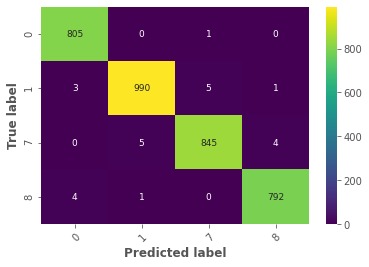

In [95]:
pred = np.argmax(mc_total_cnn_y_mean, axis=1)
converted_pred = [class_converter(i) for i in pred]
conf = confusion_matrix(y_mnist_test_original, converted_pred)
plot_confusion_matrix(conf, [0,1,7,8])

#### Epistemic part 1

In [96]:
#show_epistemic(mc_total_cnn_epistemic[0], mc_total_cnn_ensemble_pred)

In [97]:
#show_epistemic(mc_total_cnn_epistemic[0], mc_total_cnn_ensemble_pred, highest=False)

#### Epistemic part 2

In [98]:
#show_epistemic(mc_total_cnn_epistemic[1], mc_total_cnn_ensemble_pred)

In [99]:
#show_epistemic(mc_total_cnn_epistemic[1], mc_total_cnn_ensemble_pred, highest=False)

#### Epistemic part 3

In [ ]:
show_epistemic(mc_total_cnn_epistemic[2], mc_total_cnn_ensemble_pred)

In [ ]:
show_epistemic(mc_total_cnn_epistemic[2], mc_total_cnn_ensemble_pred, highest=False)

#### comparing epistemic

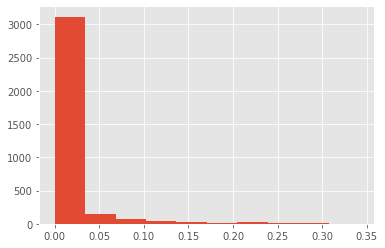

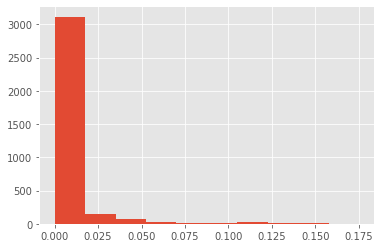

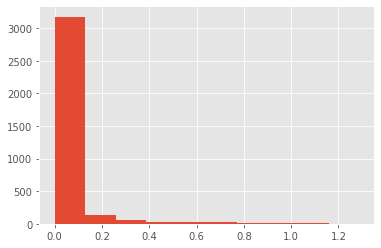

In [102]:
for i in [0,1,2]:
  plt.hist(mc_total_cnn_epistemic[i])
  plt.show()

#### aleatoric

In [103]:
"""pred_class_alea_total_cnn, sigmas_alea_total_cnn = cal_aleatoric(total_mc_cnn_model)"""

'pred_class_alea_total_cnn, sigmas_alea_total_cnn = cal_aleatoric(total_mc_cnn_model)'

In [104]:
fp = filepath + "/TEST_saved_uncertainties"
sigmas_alea_total_cnn = loadtxt(fp+'/sigmas_alea_total_mnist.csv', delimiter=',')
pred_class_alea_total_cnn = loadtxt(fp+'/pred_class_alea_total_mnist.csv', delimiter=',')

In [105]:
"""fp = (filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/sigmas_alea_total_mnist.csv', sigmas_alea_total_cnn, delimiter=',')
savetxt(fp + '/pred_class_alea_total_mnist.csv', pred_class_alea_total_cnn, delimiter=',')"""

'fp = (filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/sigmas_alea_total_mnist.csv\', sigmas_alea_total_cnn, delimiter=\',\')\nsavetxt(fp + \'/pred_class_alea_total_mnist.csv\', pred_class_alea_total_cnn, delimiter=\',\')'

In [ ]:
show_aleatoric(sigmas_alea_total_cnn, pred_class_alea_total_cnn)

In [ ]:
show_aleatoric(sigmas_alea_total_cnn, pred_class_alea_total_cnn, highest=False)

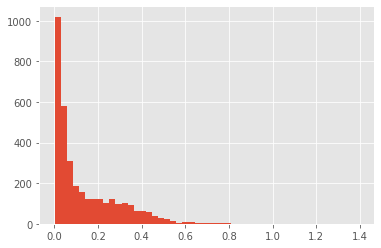

In [108]:
plt.hist(sigmas_alea_total_cnn, bins=50)
plt.show()

#### Loss attenuation?

checking if loss attenuation works as desired


In [109]:
converted_pred = np.array([class_converter(i) for i in pred_class_alea_total_cnn])
print("number of misclassified samples: ", 
      sum(converted_pred != np.array(y_mnist_test_original)))

(n_wrongclass_highalea, alea_idx, 
 true_label, pred_label) = loss_att_check(sigmas_alea_total_cnn, 
                                          pred_class_alea_total_cnn,
                                          n_alea=518) #n_alea=2953)

print(n_wrongclass_highalea, alea_idx, true_label, pred_label)

number of misclassified samples:  30
6 [1216 2545 3141  133 2983 2446] [1 1 1 7 7 8] [7 7 7 1 1 1]


In [110]:
n_wrongclass_highalea/(sum(converted_pred != np.array(y_mnist_test_original)))

0.2

# Overlap data points with highest uncertainties when using different models/calculations?

We modeled epistemic and aleatoric uncertainties separately but also jointly. Now let's see if there is an overlap in the predictions with highest uncertainty

## Epistemic

Overlap with different calculations for epistemic uncertainty:

In [111]:
# checking which samples overlap with the different types of calculating 
# epistemic uncertainty
def overlap_epistemic(all_epi, highest=True, n_epi=20):
    if highest == True:
      epi_0_idx = all_epi[0].argsort()[::-1]
      epi_1_idx = all_epi[1].argsort()[::-1]
      epi_2_idx = all_epi[2].argsort()[::-1]
    if highest == False:
      epi_0_idx = all_epi[0].argsort()
      epi_1_idx = all_epi[1].argsort()
      epi_2_idx = all_epi[2].argsort()
    overlap01 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi]])))
    overlap12 = list(set.intersection(*map(set, [epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap02 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap012 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))
    return overlap01, overlap12, overlap02, overlap012

In [112]:
# model only epistemic
n_epi = 200
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_cnn_epistemic,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [3072, 1025, 1545, 11, 1037, 3094, 23, 1560, 1051, 30, 2593, 547, 3108, 1572, 550, 2603, 48, 560, 50, 2104, 63, 1603, 2631, 1095, 79, 2639, 1107, 3159, 2649, 1625, 604, 606, 3168, 99, 1639, 1129, 622, 1137, 3192, 122, 3195, 129, 647, 136, 2699, 3215, 2706, 1684, 152, 155, 1692, 160, 3233, 676, 3238, 1194, 2733, 2734, 1711, 687, 2737, 1202, 2735, 2230, 1208, 2236, 1725, 1217, 1221, 2760, 1228, 1742, 1743, 2255, 209, 3280, 1236, 2264, 2777, 728, 2269, 1249, 2274, 2789, 748, 1772, 2802, 3315, 1268, 245, 247, 1275, 2815, 256, 2816, 1794, 2820, 773, 1289, 1295, 785, 282, 3355, 284, 3356, 1820, 801, 1316, 810, 3371, 1836, 2352, 1329, 1330, 819, 1846, 3383, 1335, 2362, 1850, 2875, 829, 832, 3393, 1863, 840, 329, 2888, 3403, 328, 1877, 342, 858, 346, 3420, 1375, 1888, 1377, 2917, 2918, 1383, 2920, 2922, 2411, 362, 2926, 879, 1904, 1390, 372, 3445, 887, 890, 3451, 381, 1918, 1919, 2431, 389, 903, 904, 2952, 906, 2962, 919, 2456, 922, 1439, 2977, 1446, 424, 937, 2989, 433, 299

In [113]:
# model both aleatoric and epistemic
n_epi = 200
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_total_cnn_epistemic,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [2560, 2049, 3074, 2050, 2052, 1025, 3087, 3089, 2578, 1566, 2594, 550, 3116, 48, 561, 50, 1586, 1584, 2104, 2618, 1086, 3137, 1603, 68, 1092, 2631, 2632, 1610, 2123, 1614, 3151, 592, 1107, 2644, 1620, 3158, 3159, 2136, 1113, 2650, 1114, 606, 2150, 1638, 2152, 1640, 1128, 1129, 110, 2672, 2673, 1138, 3192, 1662, 1663, 641, 1155, 1667, 2699, 652, 653, 139, 3212, 1676, 2707, 3220, 150, 2715, 1696, 2725, 3238, 1191, 1192, 1195, 3244, 1711, 690, 1205, 694, 185, 2236, 709, 2760, 201, 714, 2765, 3280, 209, 2773, 2779, 2781, 2782, 2783, 224, 1250, 1763, 1764, 3303, 2279, 3307, 748, 2284, 1774, 2800, 1777, 245, 762, 1275, 253, 1278, 256, 773, 3335, 2313, 2828, 3346, 789, 1815, 792, 282, 1820, 1311, 1319, 1836, 1329, 2356, 1846, 1335, 2875, 2363, 1348, 1862, 328, 1866, 333, 2893, 2896, 3409, 1873, 853, 2905, 858, 863, 865, 3429, 2918, 1383, 2921, 2411, 879, 3440, 2932, 372, 885, 887, 1909, 3451, 380, 892, 1405, 1919, 898, 388, 389, 2438, 904, 1944, 2969, 922, 1947, 2973, 1439

Result: Not big of a difference which calculation is used for uncertainty, so we stick to entropy in the next part as this is what was suggested by Yarin Gal

Overlap between the model only modeling epistemic and the model for both epistemic and aleatoric:

In [114]:
def overlap_models(uncertain_1, uncertain_2, highest=True, n=20):
    if highest == True:
      uncertain_1_idx = uncertain_1.argsort()[::-1]
      uncertain_2_idx = uncertain_2.argsort()[::-1]
    if highest == False:
      uncertain_1_idx = uncertain_1.argsort()
      uncertain_2_idx = uncertain_2.argsort()
    overlap = list(set.intersection(*map(set, [uncertain_1_idx[:n], 
                                               uncertain_2_idx[:n]])))
    return overlap

In [115]:
n = 40
overlap_epi = overlap_models(mc_cnn_epistemic[2], mc_total_cnn_epistemic[2],
                         n=n)
print("percentage of overlap: ", len(overlap_epi)/n, 
      "\nnumber of overlaps: ", len(overlap_epi),
      "\noverlap:\n", overlap_epi)

percentage of overlap:  0.4 
number of overlaps:  16 
overlap:
 [764, 3141, 583, 1704, 1809, 2545, 1331, 2868, 3314, 727, 1176, 3003, 2556, 2365, 3006, 767]


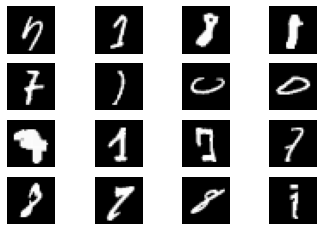

In [116]:
fig, axs = plt.subplots(4,4) 
for o, ax in zip(overlap_epi, axs.reshape(-1)):
  ax.imshow(X_mnist_test[o, :, :, 0], cmap='gist_gray')
  ax.axis('off')
plt.show()

In [117]:
n = 80
overlap_epi = overlap_models(mc_cnn_epistemic[2], mc_total_cnn_epistemic[2],
                         n=n, highest=False)
print("percentage of overlap: ", len(overlap_epi)/n, 
      "\nnumber of overlaps: ", len(overlap_epi),
      "\noverlap:\n", overlap_epi)

percentage of overlap:  0.2 
number of overlaps:  16 
overlap:
 [256, 3238, 1383, 1836, 879, 48, 1329, 887, 3063, 1846, 3159, 2104, 858, 3451, 3192, 922]


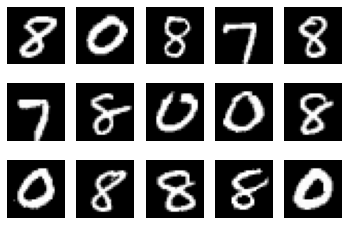

In [118]:
fig, axs = plt.subplots(3, 5) 
for o, ax in zip(overlap_epi, axs.reshape(-1)):
  ax.imshow(X_mnist_test[o, :, :, 0], cmap='gist_gray')
  ax.axis('off')
plt.show()

## Aleatoric
only calculating overlap of models

In [119]:
n = 864
overlap_alea = overlap_models(sigmas_alea_cnn, sigmas_alea_total_cnn,
                         n=n)
print("percentage of overlap: ", len(overlap_alea)/n, 
      "\nnumber of overlaps: ", len(overlap_alea),
      "\noverlap:\n", overlap_alea)

percentage of overlap:  0.17476851851851852 
number of overlaps:  151 
overlap:
 [2561, 2562, 2566, 9, 1034, 526, 3090, 1042, 549, 551, 3113, 555, 3122, 2611, 52, 1075, 54, 1588, 570, 1082, 2620, 63, 1093, 3145, 3146, 2636, 78, 1615, 598, 88, 2651, 605, 3165, 2659, 2149, 1644, 2682, 2684, 124, 1679, 144, 151, 664, 1181, 1183, 2210, 1699, 2727, 680, 2728, 3247, 3248, 177, 2737, 1203, 180, 695, 188, 1737, 2767, 724, 213, 214, 2263, 2270, 2280, 2281, 1256, 2795, 1259, 2810, 3323, 764, 1277, 254, 255, 3334, 777, 1806, 272, 1297, 2834, 786, 796, 1823, 807, 2345, 2346, 1322, 2350, 815, 3374, 1331, 1845, 1848, 826, 2890, 3403, 1867, 334, 850, 852, 2902, 2392, 345, 862, 3430, 873, 1387, 2416, 369, 370, 2419, 886, 3449, 2943, 896, 2945, 1410, 1925, 395, 398, 2447, 1425, 1428, 920, 1435, 1438, 1951, 1443, 424, 1972, 2486, 3003, 1468, 959, 454, 2506, 2513, 469, 982, 3033, 990, 483, 484, 1507, 1511, 2033, 499, 2036, 1533]


In [120]:
sigmas_alea_cnn.shape[0] * 0.25

864.0

In [121]:
sigmas_alea_cnn.shape[0]*0.15

518.4

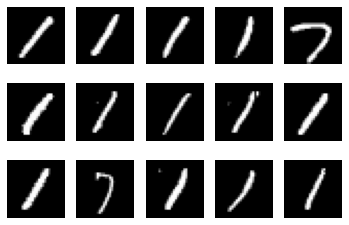

In [122]:
fig, axs = plt.subplots(3,5) 
for o, ax in zip(overlap_alea, axs.reshape(-1)):
  ax.imshow(X_mnist_test[o, :, :, 0], cmap='gist_gray')
  ax.axis('off')
plt.show()

# Visualisations

## images with highest/lowest epistemic uncertainties

In [123]:
def show_epistemic_summary(epi, highest=True, n_epi=20,
                   x_data=X_mnist_test,):
  fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  if highest == True:
    epi_idx = epi.argsort()[::-1]
  if highest == False:
    epi_idx = epi.argsort()
  for idx, ax in zip(epi_idx[:n_epi], axs.reshape(-1)):
    ax.imshow(x_data[idx, :, :, 0], cmap='gist_gray')
    ax.axis('off')
  #fig.suptitle("Main Title"),
  plt.show()

In [124]:
# function to plot n images with highest/lowest epistemic uncertanty
def show_epistemic_summary(epi, highest=True, n_epi=20,
                   x_data=X_mnist_test, save=False, filepath=filepath,
                   title="", filename=""):
  fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  gs1 = gridspec.GridSpec(4, 5)
  gs1.update(wspace=0.025, hspace=0.005) # set the spacing between axes.   
  if highest == True:
    epi_idx = epi.argsort()[::-1]
  if highest == False:
    epi_idx = epi.argsort()
  for idx, i in zip(epi_idx[:n_epi], range(20)):
    ax = plt.subplot(gs1[i])
    ax.imshow(x_data[idx, :, :, 0], cmap='gist_gray')
    ax.axis('off')
    ax.set_aspect('equal')
  
  fig.suptitle(title, fontsize=40)
  if save:
    fig.savefig(filepath + '/FINAL_plots/' + filename, 
            transparent=True, bbox_inches='tight')
  #plt.subplots_adjust(hspace = 0.01)
  plt.show()


alternating between the model only modeling epistemic and the one modeling both using different calculations for epistemic uncertainty. Also altering between showing highest and lowest uncertainty

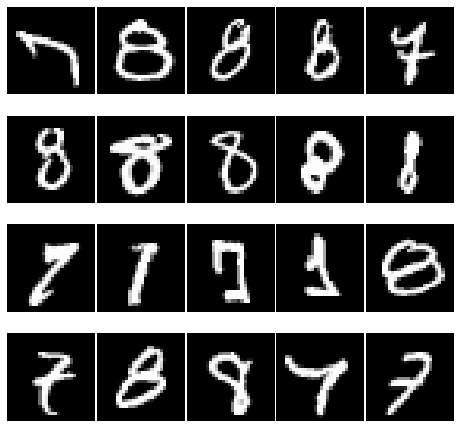

In [125]:
show_epistemic_summary(mc_total_cnn_epistemic[0])

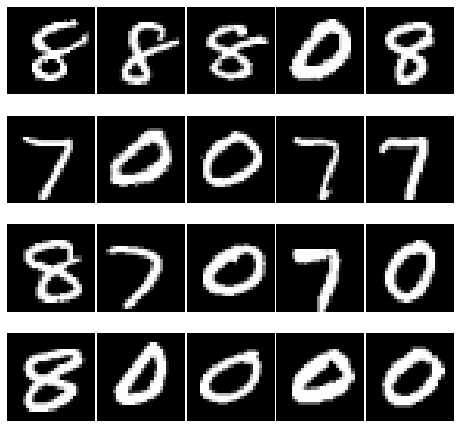

In [126]:
show_epistemic_summary(mc_cnn_epistemic[0], highest=False)

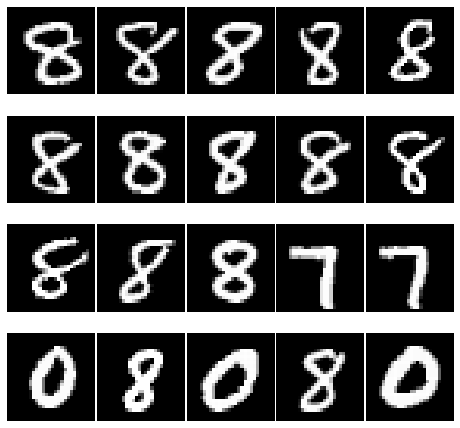

In [127]:
show_epistemic_summary(mc_total_cnn_epistemic[0], highest=False) # lowest epistemic

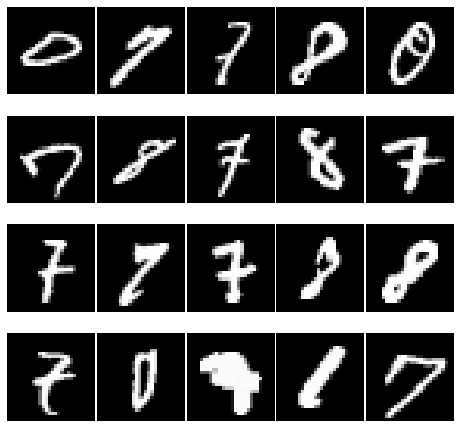

In [128]:
show_epistemic_summary(mc_cnn_epistemic[1])

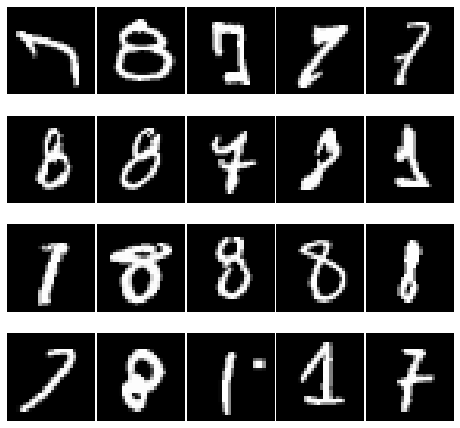

In [129]:
show_epistemic_summary(mc_total_cnn_epistemic[1])

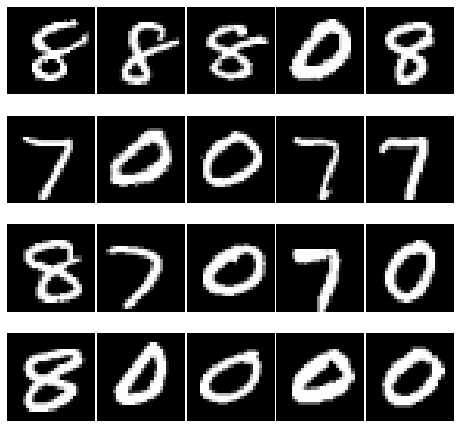

In [130]:
show_epistemic_summary(mc_cnn_epistemic[0], highest=False)

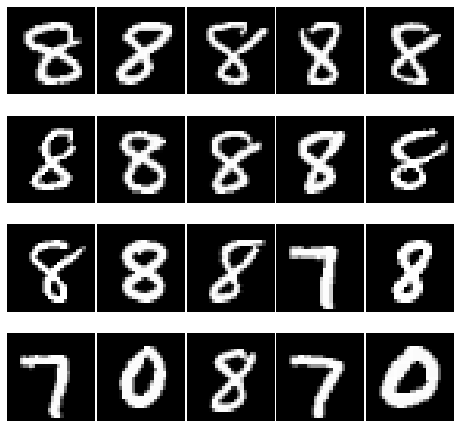

In [131]:
show_epistemic_summary(mc_total_cnn_epistemic[1], highest=False) # lowest epistemic

In [132]:
"""show_epistemic_summary(mc_cnn_epistemic[2],
        save=True, filename="highest_epistemic_mnist.png",
        title="highest epistemic")"""

'show_epistemic_summary(mc_cnn_epistemic[2],\n        save=True, filename="highest_epistemic_mnist.png",\n        title="highest epistemic")'

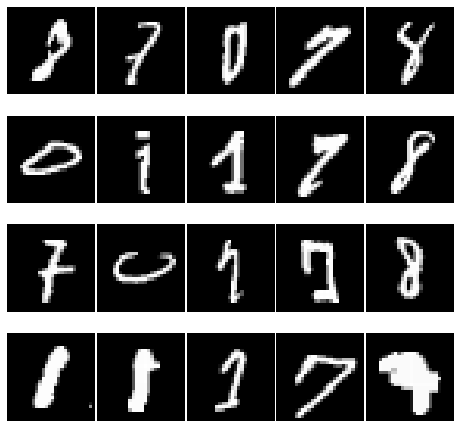

In [133]:
show_epistemic_summary(mc_cnn_epistemic[2])

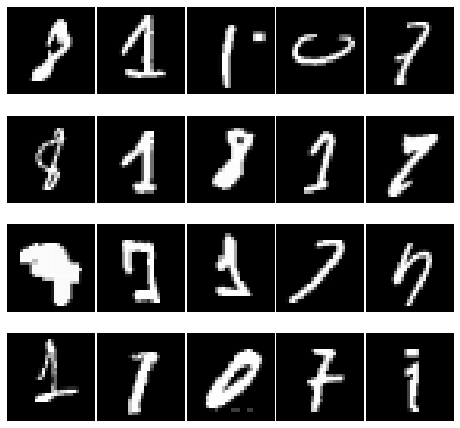

In [134]:
show_epistemic_summary(mc_total_cnn_epistemic[2]) # highest epistemic

In [135]:
"""show_epistemic_summary(mc_cnn_epistemic[2], highest=False, 
        save=True, filename="lowest_epistemic_mnist.png",
        title="lowest epistemic")"""

'show_epistemic_summary(mc_cnn_epistemic[2], highest=False, \n        save=True, filename="lowest_epistemic_mnist.png",\n        title="lowest epistemic")'

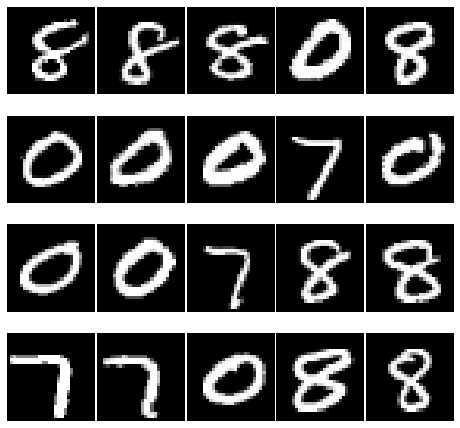

In [136]:
show_epistemic_summary(mc_cnn_epistemic[2], highest=False)

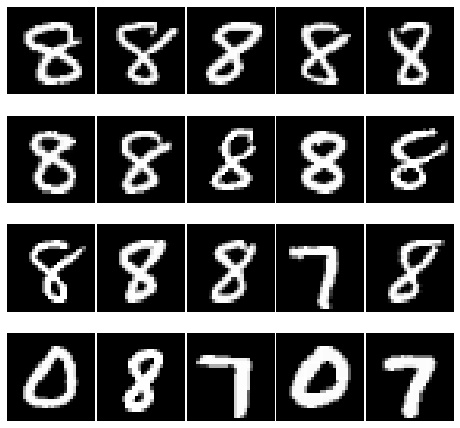

In [137]:
show_epistemic_summary(mc_total_cnn_epistemic[2], highest=False) # lowest epistemic

## images with highest/lowest aleatoric uncertainties

In [138]:
# function to plot n images with highest/lowest aleatoric uncertanty
def show_aleatoric_summary(sigmas, highest=True, n_alea=20,
                   x_data=X_mnist_test, save=False, filepath=filepath,
                   title="", filename=""):
  fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  gs1 = gridspec.GridSpec(4, 5)
  gs1.update(wspace=0.025, hspace=0.005) # set the spacing between axes. 
  
  if highest == True:
    alea_idx = sigmas.argsort()[::-1]
  if highest == False:
    alea_idx = sigmas.argsort()
  
  for idx, i in zip(alea_idx[:n_alea], range(20)):
    ax = plt.subplot(gs1[i])
    ax.imshow(x_data[idx, :, :, 0], cmap='gist_gray')
    ax.axis('off')
    ax.set_aspect('equal')
  
  fig.suptitle(title, fontsize=40)
  if save:
    fig.savefig(filepath + '/FINAL_plots/' + filename, 
            transparent=True, bbox_inches='tight')
  #plt.subplots_adjust(hspace = 0.01)
  plt.show()



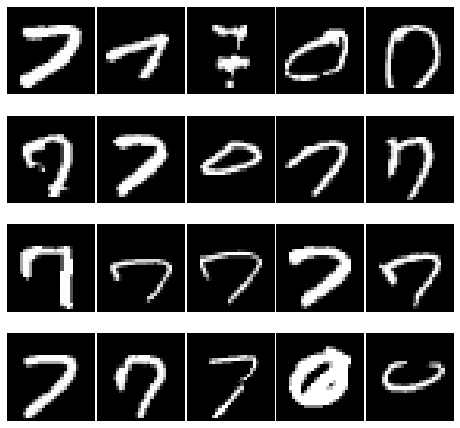

In [139]:
show_aleatoric_summary(sigmas_alea_cnn)

In [140]:
"""show_aleatoric_summary(sigmas_alea_cnn, save=True, 
title="highest aleatoric", filename="highest_alea_mnist.png")"""

'show_aleatoric_summary(sigmas_alea_cnn, save=True, \ntitle="highest aleatoric", filename="highest_alea_mnist.png")'

In [141]:
"""show_aleatoric_summary(sigmas_alea_cnn, save=True, highest=False,
              title="lowest aleatoric", filename="lowest_alea_mnist")"""

'show_aleatoric_summary(sigmas_alea_cnn, save=True, highest=False,\n              title="lowest aleatoric", filename="lowest_alea_mnist")'

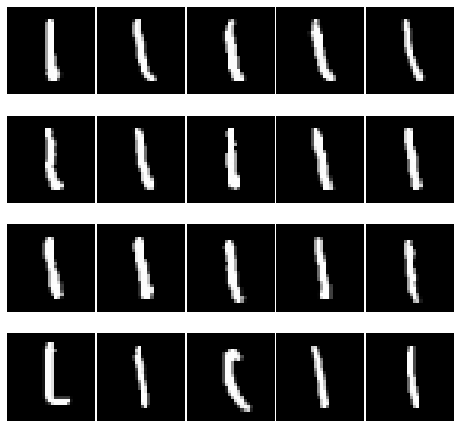

In [142]:
show_aleatoric_summary(sigmas_alea_cnn, highest=False)

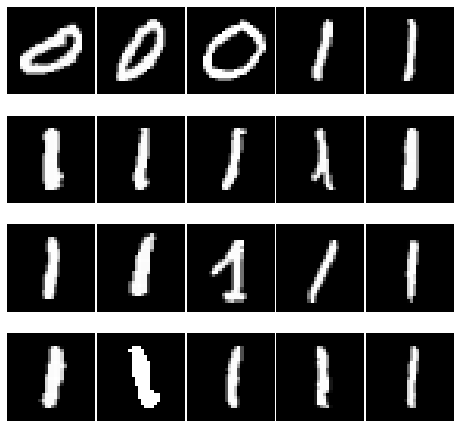

In [143]:
show_aleatoric_summary(sigmas_alea_total_cnn)

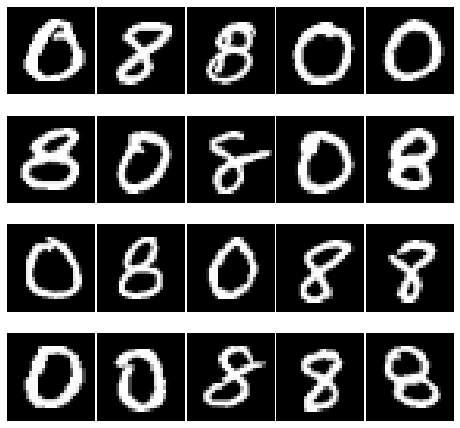

In [144]:
show_aleatoric_summary(sigmas_alea_total_cnn, highest=False)

##### investigating where aleatoric uncertainties come from


In [145]:
# need original format of data
(df_mnist, _, _,
            X_mnist_test_original, _,
            _, _,
            _, _) = get_mnist_data()

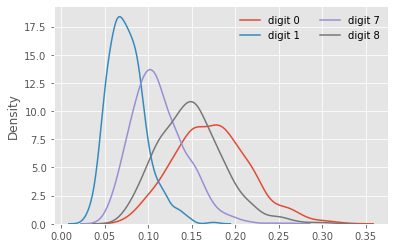

In [146]:
# this is how the intensities of the pixels are distributed
mean_intensity = np.mean(X_mnist_test_original,axis=1)
fig, ax = plt.subplots()
for i in [0,1,7,8]:
  sns.kdeplot(mean_intensity[y_mnist_test_original==i],
              label="digit "+str(i))
ax.legend(frameon=False, ncol=2) 
plt.show()

Digits 0 and 8 have on average higher mean pixel intensities, whereas digit intensity is smaller for 1 and 7. 

In [147]:
q3, q1 = np.percentile(mean_intensity[y_mnist_test_original==1], [5, 95])

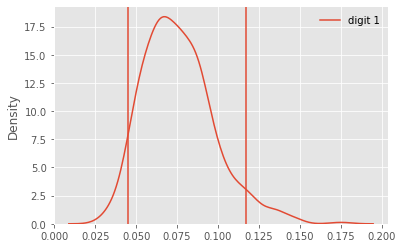

In [148]:
mean_intensity = np.mean(X_mnist_test_original,axis=1)
fig, ax = plt.subplots()
for i in [1]:
  sns.kdeplot(mean_intensity[y_mnist_test_original==i],
              label="digit "+str(i))
  #conf = mean_confidence_interval(mean_intensity[y_mnist_test_original==i],
   #                               confidence=0.99)
  conf = np.percentile(mean_intensity[y_mnist_test_original==i], [5, 95])
  ax.axvline(conf[0])
  ax.axvline(conf[1])
ax.legend(frameon=False, ncol=2) 
plt.show()

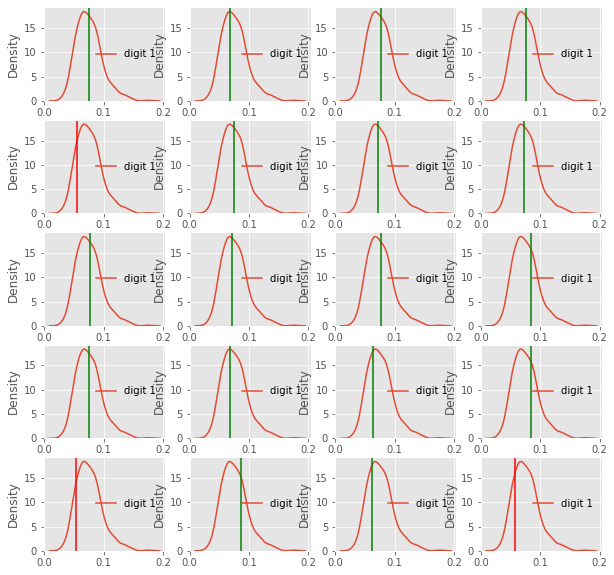

17 in CI
0.85 % in CI


In [149]:
# get the mean intensities for digits with high aleatoric uncertainty
n = 20
alea_idx = sigmas_alea_cnn.argsort()#[::-1]
#alea_idx = sigmas_alea_total_cnn.argsort()#[::-1]
alea_idx_selected = alea_idx[:n]
mean_intensity = np.mean(X_mnist_test_original,axis=1)

in_ci = 0
fig, axs = plt.subplots(5,4, figsize=(10,10))
for idx, ax in zip(alea_idx_selected, axs.reshape(-1)):
  true_class = y_mnist_test_original.iloc[idx]
  sns.kdeplot(mean_intensity[y_mnist_test_original==true_class],
                label="digit "+str(true_class), ax=ax)
  ax.legend(frameon=False, ncol=2) 

  means_class = mean_intensity[y_mnist_test_original==true_class]
  conf = np.percentile(means_class, [25, 75])
  ci = [round(conf[0], 3), 
        round(conf[1], 3)]
  if ci[0] <= np.mean(X_mnist_test_original.iloc[idx]) <= ci[1]:
    ax.axvline(np.mean(X_mnist_test_original.iloc[idx]), color="green")
    in_ci = in_ci +1
  else:
    ax.axvline(np.mean(X_mnist_test_original.iloc[idx]), color="red")
  ax.set_xlabel("")
plt.show()
print(in_ci, "in CI")
print(in_ci/n, "% in CI")

Consider distribution of the pixel intensity for each digits. 

With **model 2**, the samples with lowest aleatoric features all 100% have mean intensity between 5th and 95th percentile, whereas for samples with highest aleatoric uncertainty, the mean pixel intensity lies outside 5th and 95th percentile 40% of the time, and 75% of the time outside the range between 25th and 75th quantile. Lowest aleatoric uncertainties: 85% inside 25th and 75th quantile, 100% inside 5th and 95th percentile

For **model 3**,  25% of the time outside the 5th and 95th percentile, and 60% of the time outside the 25th and 75th percentile. For the lowest aleatoric, 95% lie in 5th and 95th percentile and 60% inside 25th and 75th quantile. Lowest uncertainties, the other way round: 60% lie inside 25th and 75th percentile and 95% 5th and 95th percentile

## check if epistemic decreases with more data

function to calculate epistemic uncertainties for different training sizes

In [150]:
"""def check_epistemic(X_train, y_train, X_test, y_test, sample_sizes, model, 
                    random_state=10):
  # for loop to calculate epistemic uncertainties for different sample sizes
  epi_list = []
  epi_mean_list = []

  for sample_size in sample_sizes:
      # create differnt training sizes
      (X_train_helper, _, 
      y_train_helper, _) = train_test_split(X_train, 
                                            y_train,
                                            test_size=1-sample_size,
                                            random_state=random_state)
      
      mc_model_cnn_helper = model_creator(act="relu", dropout_prob=0.25,
                             learning_rate=0.01)
      
      mc_history_cnn_helper = mc_model_cnn_helper.fit(X_train_helper, y_train_helper, 
                                    validation_data=(X_test, y_test), 
                                    batch_size=256, epochs=20,
                                    verbose=0)
      
      # calculate epistemic uncertainties
      mc_predictions_helper = make_predictions(mc_model_cnn_helper)
      _, _, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
      epi_list.append(mc_epistemic_helper)
      epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  # repeat for the original model as well (i.e. with full training set)
  mc_predictions_helper = make_predictions(model)
  _, _, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
  epi_list.append(mc_epistemic_helper)
  epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  return epi_list, epi_mean_list"""

'def check_epistemic(X_train, y_train, X_test, y_test, sample_sizes, model, \n                    random_state=10):\n  # for loop to calculate epistemic uncertainties for different sample sizes\n  epi_list = []\n  epi_mean_list = []\n\n  for sample_size in sample_sizes:\n      # create differnt training sizes\n      (X_train_helper, _, \n      y_train_helper, _) = train_test_split(X_train, \n                                            y_train,\n                                            test_size=1-sample_size,\n                                            random_state=random_state)\n      \n      mc_model_cnn_helper = model_creator(act="relu", dropout_prob=0.25,\n                             learning_rate=0.01)\n      \n      mc_history_cnn_helper = mc_model_cnn_helper.fit(X_train_helper, y_train_helper, \n                                    validation_data=(X_test, y_test), \n                                    batch_size=256, epochs=20,\n                                    verbose=0

Try sample sizes ```sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]``` with ```random_state=5```

In [151]:
"""num_classes = 4
input_shape = (28, 28, 1)
sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

epi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, 
                          X_test=X_mnist_test, y_test=y_mnist_test, 
                          sample_sizes=sample_sizes, model=mc_model_cnn,
                          random_state=5)"""

'num_classes = 4\ninput_shape = (28, 28, 1)\nsample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]\n\nepi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, \n                          X_test=X_mnist_test, y_test=y_mnist_test, \n                          sample_sizes=sample_sizes, model=mc_model_cnn,\n                          random_state=5)'

In [152]:
"""x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] 
x_samples.append(X_mnist_train.shape[0])
for i in range(len(epi_mean_list[0])):
  y_epi = [epi[i] for epi in epi_mean_list]
  plt.plot(x_samples, y_epi)"""

'x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] \nx_samples.append(X_mnist_train.shape[0])\nfor i in range(len(epi_mean_list[0])):\n  y_epi = [epi[i] for epi in epi_mean_list]\n  plt.plot(x_samples, y_epi)'

Try sample sizes ```sample_sizes = [0.25, 0.5, 0.75]``` with ```random_state=301```

In [153]:
"""num_classes = 4
input_shape = (28, 28, 1)
sample_sizes = [0.25, 0.5, 0.75]

epi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, 
                          X_test=X_mnist_test, y_test=y_mnist_test, 
                          sample_sizes=sample_sizes, model=mc_model_cnn,
                          random_state=301)

x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] 
x_samples.append(X_mnist_train.shape[0])
for i in range(len(epi_mean_list[0])):
  y_epi = [epi[i] for epi in epi_mean_list]
  plt.plot(x_samples, y_epi)"""

'num_classes = 4\ninput_shape = (28, 28, 1)\nsample_sizes = [0.25, 0.5, 0.75]\n\nepi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, \n                          X_test=X_mnist_test, y_test=y_mnist_test, \n                          sample_sizes=sample_sizes, model=mc_model_cnn,\n                          random_state=301)\n\nx_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] \nx_samples.append(X_mnist_train.shape[0])\nfor i in range(len(epi_mean_list[0])):\n  y_epi = [epi[i] for epi in epi_mean_list]\n  plt.plot(x_samples, y_epi)'

Interesting to check the influence of the specific data sets used for training. I.e. how much of a difference it makes when changing the ```random_state``` in ```train_test_split```

In [154]:
"""import random
num_classes = 4
input_shape = (28, 28, 1)
sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

for _ in range(10): 
  random_state = random.randint(1,1e4)
  print(f"random state is {random_state}")
  epi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, 
                            X_test=X_mnist_test, y_test=y_mnist_test, 
                            sample_sizes=sample_sizes, model=mc_model_cnn, 
                            random_state=random_state)

  x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] 
  x_samples.append(X_mnist_train.shape[0])
  for i in range(len(epi_mean_list[0])):
    y_epi = [epi[i] for epi in epi_mean_list]
    plt.plot(x_samples, y_epi)
  plt.show()"""

'import random\nnum_classes = 4\ninput_shape = (28, 28, 1)\nsample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]\n\nfor _ in range(10): \n  random_state = random.randint(1,1e4)\n  print(f"random state is {random_state}")\n  epi_list, epi_mean_list = check_epistemic(X_train=X_mnist_train, y_train=y_mnist_train, \n                            X_test=X_mnist_test, y_test=y_mnist_test, \n                            sample_sizes=sample_sizes, model=mc_model_cnn, \n                            random_state=random_state)\n\n  x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] \n  x_samples.append(X_mnist_train.shape[0])\n  for i in range(len(epi_mean_list[0])):\n    y_epi = [epi[i] for epi in epi_mean_list]\n    plt.plot(x_samples, y_epi)\n  plt.show()'

Summary of the above results: whether epistemic uncertainty decreases with an increase in training data, is highly dependent on the which data are present in the smallest training data set, and which data points are then added to increase training set size. 


With ```random state 301```, for instance, we observe a bahaviour as described by Yarin Gal. With ```random state 7888``` or ```random state is 6238``` however, the epistemic uncertainty fluctuatates up and down or mainly increases, respectively. 

Another observation that can be made at this point: it does not seem to make a difference in terms of which calculation of epistemic uncertainty is used (max std, mean std, entropy). The uncertainty levels differ, however, seem to be highly correlated.

## check if aleatoric decreases with more data

In [155]:
"""def check_aleatoric(X_train, y_train, X_test, y_test, sample_sizes, model, 
                    random_state=10):
  # for loop to calculate epistemic uncertainties for different sample sizes
  sigmas_list = []
  sigmas_mean_list = []

  num_classes = 4
  T = 30
  loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

  for sample_size in sample_sizes:
      # create differnt training sizes
      (X_train_helper, _, 
      y_train_helper, _) = train_test_split(X_train, 
                                            y_train,
                                            test_size=1-sample_size,
                                            random_state=random_state)
      
      alea_model_cnn_helper = model_creator(act="relu", dropout_prob=0.0,
                                  learning_rate=0.01,
                                  include_logvar=True, loss=loss_fn)
      alea_cnn_history_helper = alea_model_cnn_helper.fit(X_train_helper, y_train_helper, 
                                  validation_data=(X_test, y_test),
                                  batch_size=256, epochs=20, verbose=0)
      
      # calculate aleatoric uncertainties
      _, sigmas_alea_cnn_helper = cal_aleatoric(alea_model_cnn_helper)
      sigmas_list.append(sigmas_alea_cnn_helper)
      sigmas_mean_list.append(np.mean(sigmas_alea_cnn_helper))

  # repeat for the original model as well (i.e. with full training set)
  _, sigmas_alea_cnn_helper = cal_aleatoric(model)
  sigmas_list.append(sigmas_alea_cnn_helper)
  sigmas_mean_list.append(np.mean(sigmas_alea_cnn_helper))

  return sigmas_list, sigmas_mean_list"""

'def check_aleatoric(X_train, y_train, X_test, y_test, sample_sizes, model, \n                    random_state=10):\n  # for loop to calculate epistemic uncertainties for different sample sizes\n  sigmas_list = []\n  sigmas_mean_list = []\n\n  num_classes = 4\n  T = 30\n  loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)\n\n  for sample_size in sample_sizes:\n      # create differnt training sizes\n      (X_train_helper, _, \n      y_train_helper, _) = train_test_split(X_train, \n                                            y_train,\n                                            test_size=1-sample_size,\n                                            random_state=random_state)\n      \n      alea_model_cnn_helper = model_creator(act="relu", dropout_prob=0.0,\n                                  learning_rate=0.01,\n                                  include_logvar=True, loss=loss_fn)\n      alea_cnn_history_helper = alea_model_cnn_helper.fit(X_train_helper, y_train_helpe

In [156]:
"""num_classes = 4
input_shape = (28, 28, 1)
sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

sigmas_list, sigmas_mean_list = check_aleatoric(X_train=X_mnist_train, y_train=y_mnist_train, 
                          X_test=X_mnist_test, y_test=y_mnist_test, 
                          sample_sizes=sample_sizes, model=alea_model_cnn,
                          random_state=5)"""

'num_classes = 4\ninput_shape = (28, 28, 1)\nsample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]\n\nsigmas_list, sigmas_mean_list = check_aleatoric(X_train=X_mnist_train, y_train=y_mnist_train, \n                          X_test=X_mnist_test, y_test=y_mnist_test, \n                          sample_sizes=sample_sizes, model=alea_model_cnn,\n                          random_state=5)'

In [157]:
"""x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] 
x_samples.append(X_mnist_train.shape[0])
plt.plot(x_samples, sigmas_mean_list)
plt.scatter(x_samples, sigmas_mean_list)"""

'x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] \nx_samples.append(X_mnist_train.shape[0])\nplt.plot(x_samples, sigmas_mean_list)\nplt.scatter(x_samples, sigmas_mean_list)'

In [158]:
"""num_classes = 4
input_shape = (28, 28, 1)
sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

for _ in range(5): 
  random_state = random.randint(1,1e4)
  print(f"random state is {random_state}")
  sigmas_list, sigmas_mean_list = check_aleatoric(X_train=X_mnist_train, y_train=y_mnist_train, 
                          X_test=X_mnist_test, y_test=y_mnist_test, 
                          sample_sizes=sample_sizes, model=alea_model_cnn,
                          random_state=random_state)

  x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] 
  x_samples.append(X_mnist_train.shape[0])
  plt.plot(x_samples, sigmas_mean_list)
  plt.scatter(x_samples, sigmas_mean_list)
  plt.show()"""

'num_classes = 4\ninput_shape = (28, 28, 1)\nsample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]\n\nfor _ in range(5): \n  random_state = random.randint(1,1e4)\n  print(f"random state is {random_state}")\n  sigmas_list, sigmas_mean_list = check_aleatoric(X_train=X_mnist_train, y_train=y_mnist_train, \n                          X_test=X_mnist_test, y_test=y_mnist_test, \n                          sample_sizes=sample_sizes, model=alea_model_cnn,\n                          random_state=random_state)\n\n  x_samples = [i * X_mnist_train.shape[0] for i in sample_sizes] \n  x_samples.append(X_mnist_train.shape[0])\n  plt.plot(x_samples, sigmas_mean_list)\n  plt.scatter(x_samples, sigmas_mean_list)\n  plt.show()'

## effect on accuracy when deleting data points with highest uncertainties



In [159]:
"""del_percentage = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
def check_acc(model, uncertainty, 
              del_percentage=del_percentage):
  accuracy_list = []
  loss_list = []
  sorted_uncertainty = uncertainty.argsort()[::-1]
  n = uncertainty.shape[0]
  for d in del_percentage:
      # drop the samples with highest uncertainty
      print(f"delete the {int(n*d)} highest uncertainties")
      drop_highest = sorted_uncertainty[int(n*d):]
      loss, accuracy = model.evaluate(X_mnist_test[drop_highest], 
                                      y_mnist_test[drop_highest], 
                                      verbose=0)
      print(f"Eval loss = {loss}, Eval accuracy = {accuracy}")
      loss_list.append(loss)
      accuracy_list.append(accuracy)
  return loss_list, accuracy_list"""

'del_percentage = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]\ndef check_acc(model, uncertainty, \n              del_percentage=del_percentage):\n  accuracy_list = []\n  loss_list = []\n  sorted_uncertainty = uncertainty.argsort()[::-1]\n  n = uncertainty.shape[0]\n  for d in del_percentage:\n      # drop the samples with highest uncertainty\n      print(f"delete the {int(n*d)} highest uncertainties")\n      drop_highest = sorted_uncertainty[int(n*d):]\n      loss, accuracy = model.evaluate(X_mnist_test[drop_highest], \n                                      y_mnist_test[drop_highest], \n                                      verbose=0)\n      print(f"Eval loss = {loss}, Eval accuracy = {accuracy}")\n      loss_list.append(loss)\n      accuracy_list.append(accuracy)\n  return loss_list, accuracy_list'

In [160]:
"""loss_list_total_mc_cnn, accuracy_list_total_mc_cnn = check_acc(model=total_mc_cnn_model, 
                                                               uncertainty=mc_total_cnn_epistemic[2])"""

'loss_list_total_mc_cnn, accuracy_list_total_mc_cnn = check_acc(model=total_mc_cnn_model, \n                                                               uncertainty=mc_total_cnn_epistemic[2])'

In [161]:
"""plt.plot(del_percentage, accuracy_list_total_mc_cnn)
plt.scatter(del_percentage, accuracy_list_total_mc_cnn)"""

'plt.plot(del_percentage, accuracy_list_total_mc_cnn)\nplt.scatter(del_percentage, accuracy_list_total_mc_cnn)'

In [162]:
"""loss_list_total_mc_cnn_alea, accuracy_list_total_mc_cnn_alea = check_acc(model=total_mc_cnn_model, 
                                                               uncertainty=sigmas_alea_total_cnn)"""

'loss_list_total_mc_cnn_alea, accuracy_list_total_mc_cnn_alea = check_acc(model=total_mc_cnn_model, \n                                                               uncertainty=sigmas_alea_total_cnn)'

In [163]:
"""plt.plot(del_percentage, accuracy_list_total_mc_cnn_alea)
plt.scatter(del_percentage, accuracy_list_total_mc_cnn_alea)"""

'plt.plot(del_percentage, accuracy_list_total_mc_cnn_alea)\nplt.scatter(del_percentage, accuracy_list_total_mc_cnn_alea)'

<a name="cell-id"></a>
## TSNE

plotting LOF and BNN results with TSNE reduced test data

In [164]:
from sklearn.manifold import TSNE
X_mnist_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X_mnist_test_original)

In [165]:
from sklearn.neighbors import LocalOutlierFactor
clf_val = LocalOutlierFactor(n_neighbors=2)
result_2_val = clf_val.fit_predict(X_mnist_test_original)

clf_val_3 = LocalOutlierFactor(n_neighbors=3)
result_3_val = clf_val_3.fit_predict(X_mnist_test_original)

clf_val_10 = LocalOutlierFactor(n_neighbors=10)
result_10_val = clf_val_10.fit_predict(X_mnist_test_original)

clf_val_cont = LocalOutlierFactor(contamination=0.001428)
result_cont_val = clf_val_cont.fit_predict(X_mnist_test_original)

In [166]:
outlier_index_val = np.where(result_2_val == -1)
X_scores_val = clf_val.negative_outlier_factor_
print(len(outlier_index_val[0]))

outlier_index_val_3 = np.where(result_3_val == -1)
X_scores_val_3 = clf_val_3.negative_outlier_factor_
print(len(outlier_index_val_3[0]))

outlier_index_val_10 = np.where(result_10_val == -1)
X_scores_val_10 = clf_val_10.negative_outlier_factor_
print(len(outlier_index_val_10[0]))

outlier_index_val_cont = np.where(result_cont_val == -1)
X_scores_val_cont = clf_val_cont.negative_outlier_factor_
print(len(outlier_index_val_cont[0]))

95
81
72
5


Look at outliers predicted with LOF

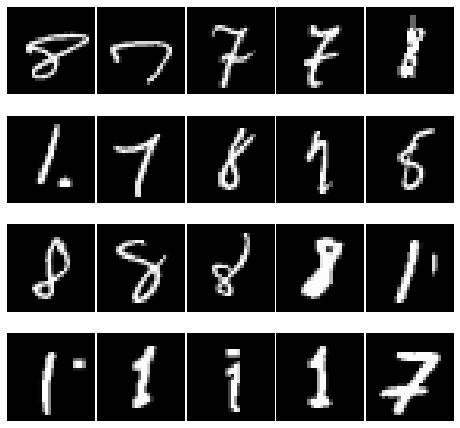

In [167]:
fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace=0.025, hspace=0.005)
LOFidx = np.where(result_3_val <= -1)[0]
for idx, i in zip(LOFidx[:20], range(20)):
  ax = plt.subplot(gs1[i])
  ax.imshow(X_mnist_test[idx, :, :, 0], cmap='gist_gray')
  ax.axis('off')
  ax.set_aspect('equal')
#fig.savefig(filepath + '/FINAL_plots/' + "LOFexamples", 
#            transparent=True, bbox_inches='tight')
plt.show()

In [168]:
n = 200
# uncertainty_all = mc_cnn_epistemic[2].argsort()[::-1]
uncertainty_all = sigmas_alea_total_cnn.argsort()[::-1]
uncertainty = uncertainty_all[:n]

In [169]:
np.intersect1d(LOFidx, uncertainty)

array([1216, 1644, 1977, 2634, 2686, 2743, 3115, 3293])

### epistemic

highest epistemic uncertainties using model 1

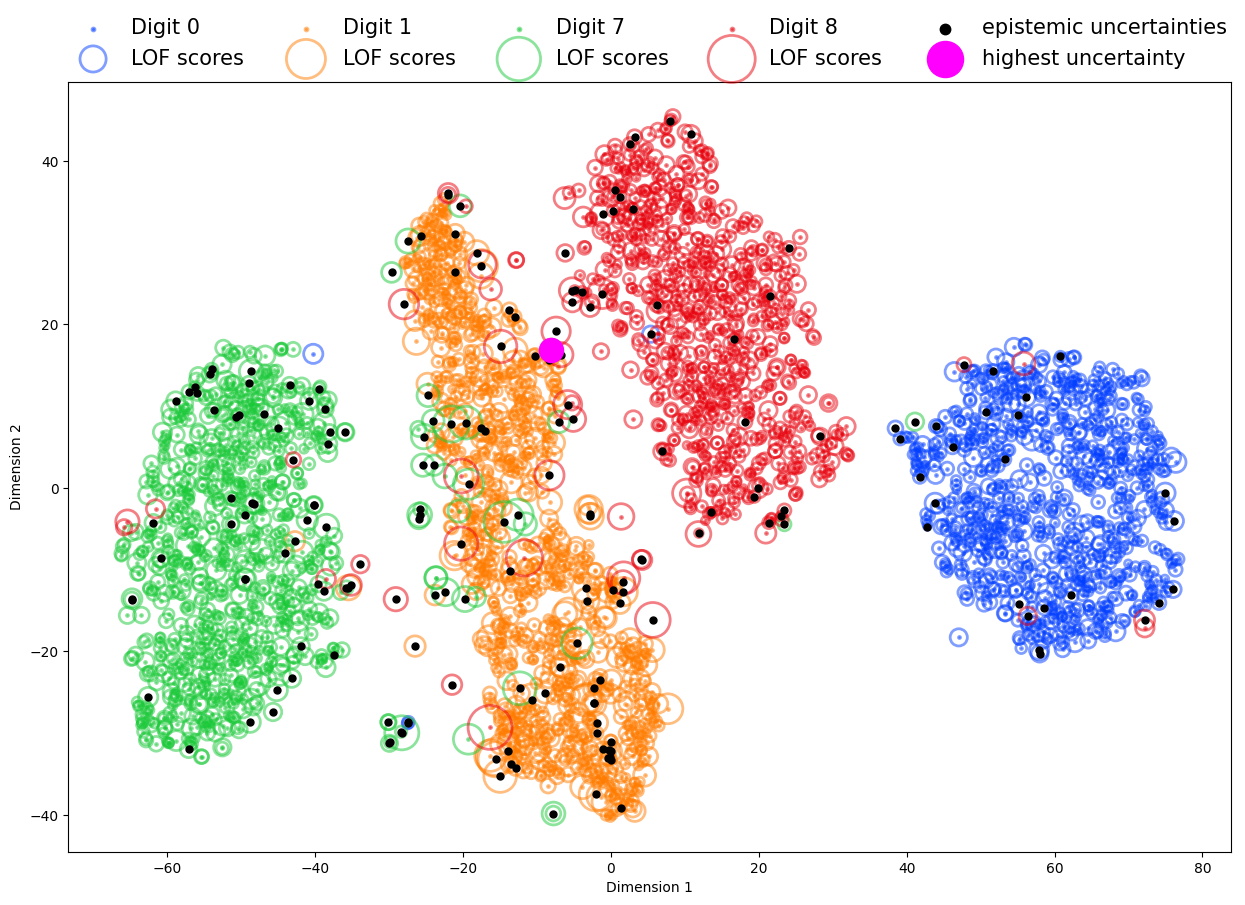

In [174]:
# new
epi_idx_total = mc_cnn_epistemic[2].argsort()[::-1]
uncertainty = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_epistemic_mnist.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()#

highest epistemic uncertainties using model 3

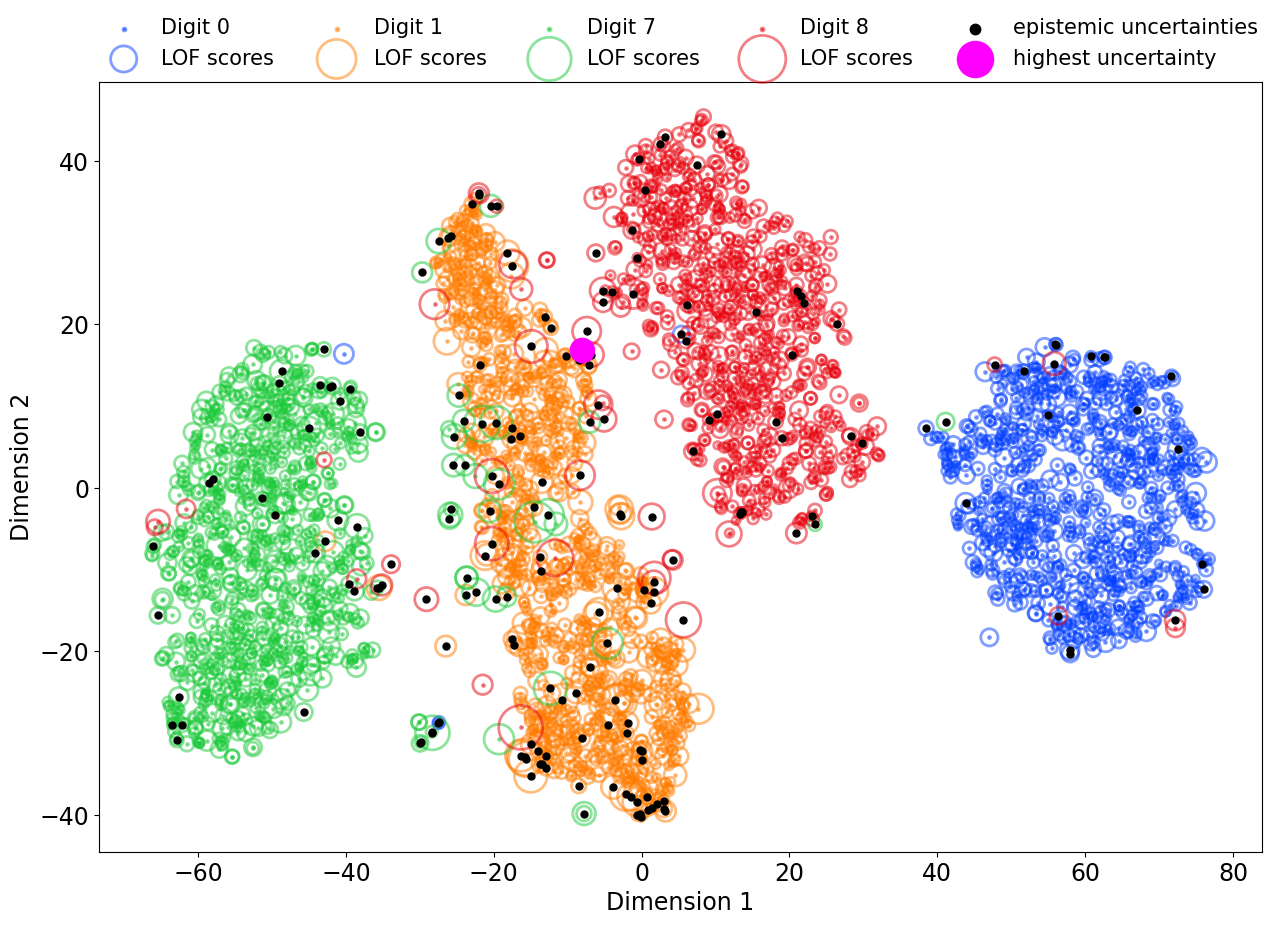

In [175]:
plt.rcParams.update({'font.size': 17})
epi_idx_total = mc_total_cnn_epistemic[2].argsort()[::-1]
uncertainty = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]

fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_epistemic_mnist.png', 
#            transparent=True, bbox_inches='tight')

plt.show()

In [176]:
np.intersect1d(LOFidx, uncertainty)

array([  66,  100,  114,  268,  343,  471,  524,  583,  669,  767,  811,
        838, 1039, 1163, 1216, 1345, 1458, 1464, 1556, 1644, 1704, 1734,
       1775, 1809, 1833, 1847, 1870, 1878, 1898, 1977, 2143, 2244, 2421,
       2484, 2559, 2685, 2686, 2688, 2698, 2743, 2876, 2983, 3046, 3173,
       3267, 3368, 3402])

lowest epistemic uncertainties using model 1

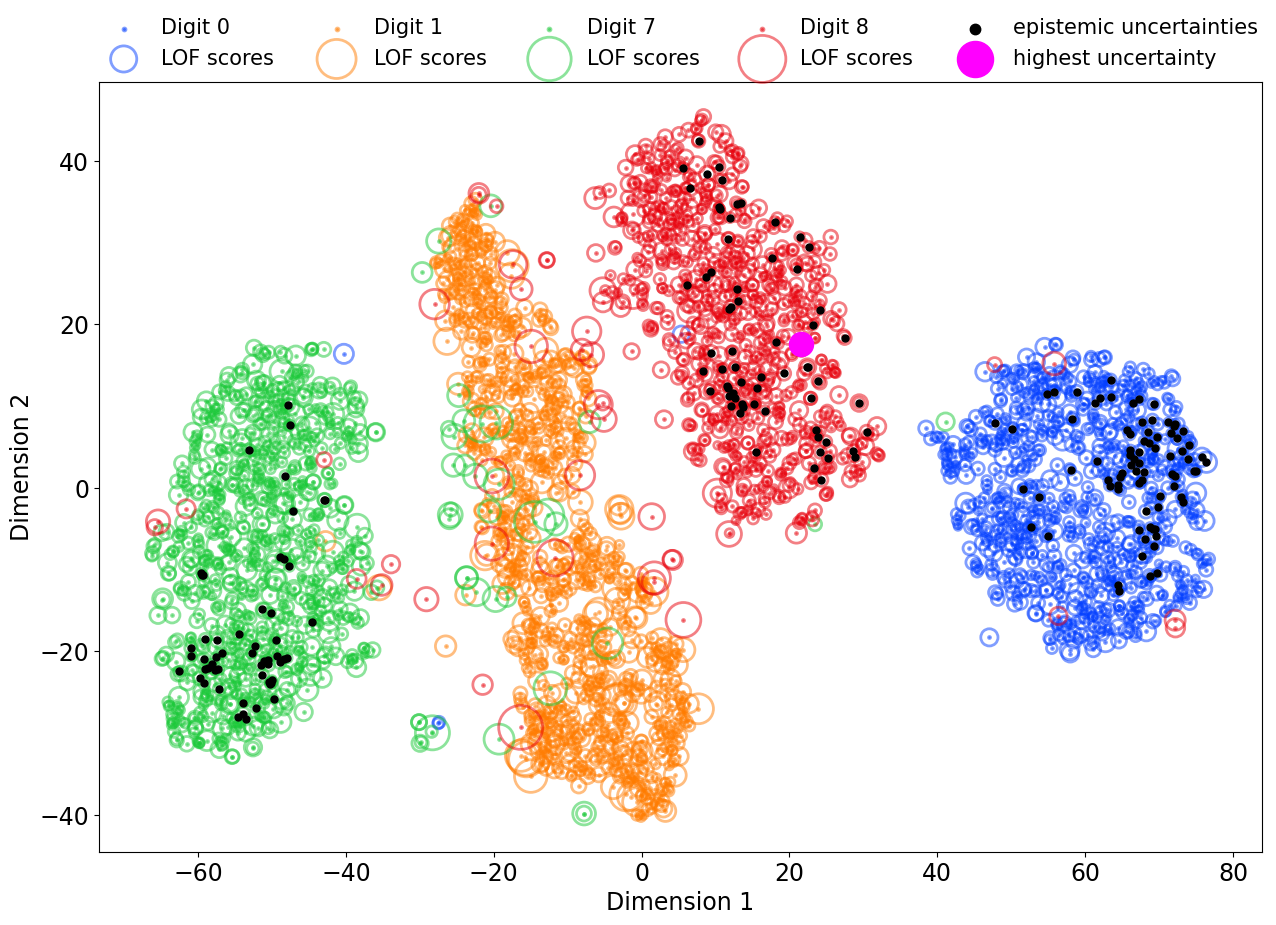

In [177]:
epi_idx_total = mc_cnn_epistemic[2].argsort()
uncertainty = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_epistemic_lowest.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()

lowest epistemic uncertainties using model 3

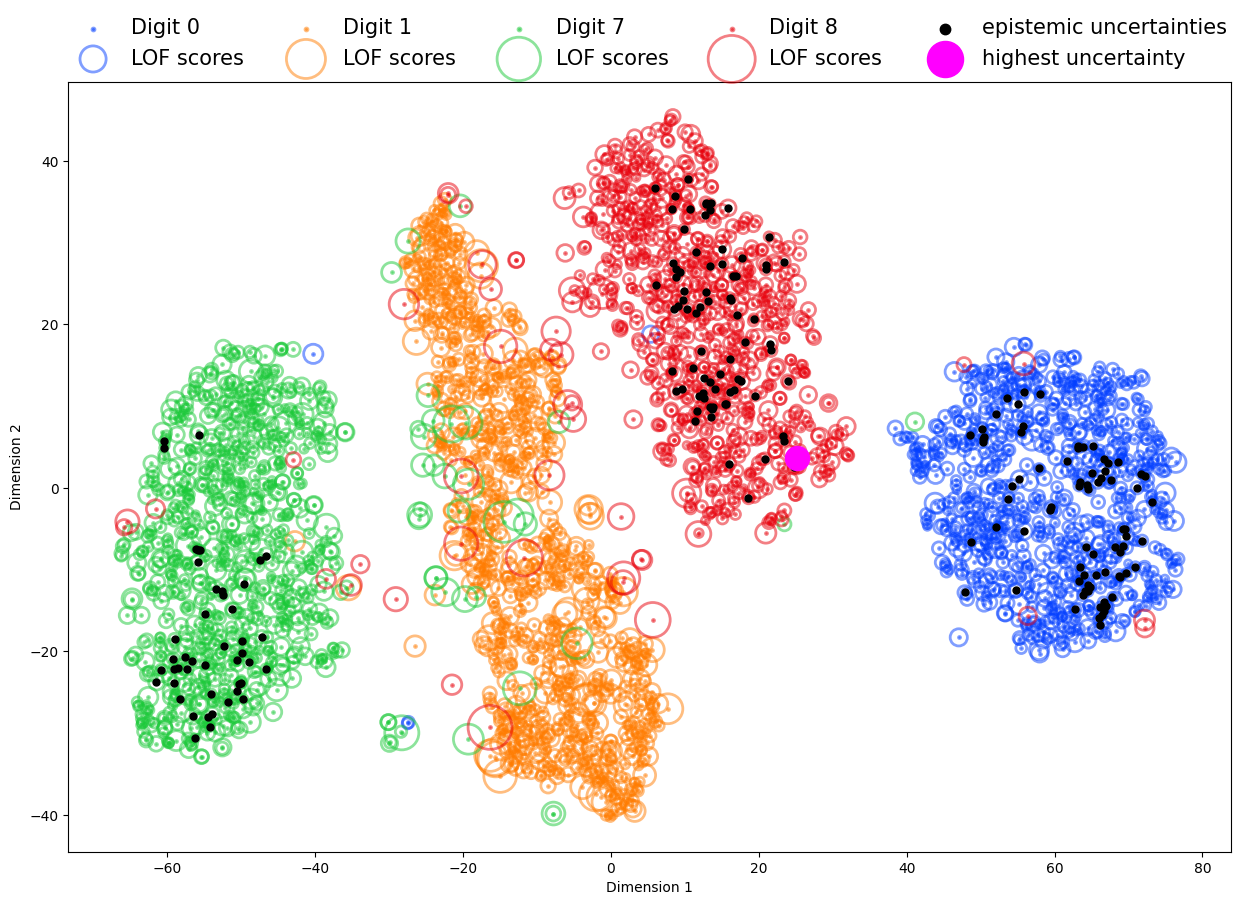

In [178]:
epi_idx_total = mc_total_cnn_epistemic[2].argsort()
uncertainty = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_epistemic_lowest.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()

### aleatoric

highest aleatoric uncertainties using model 2

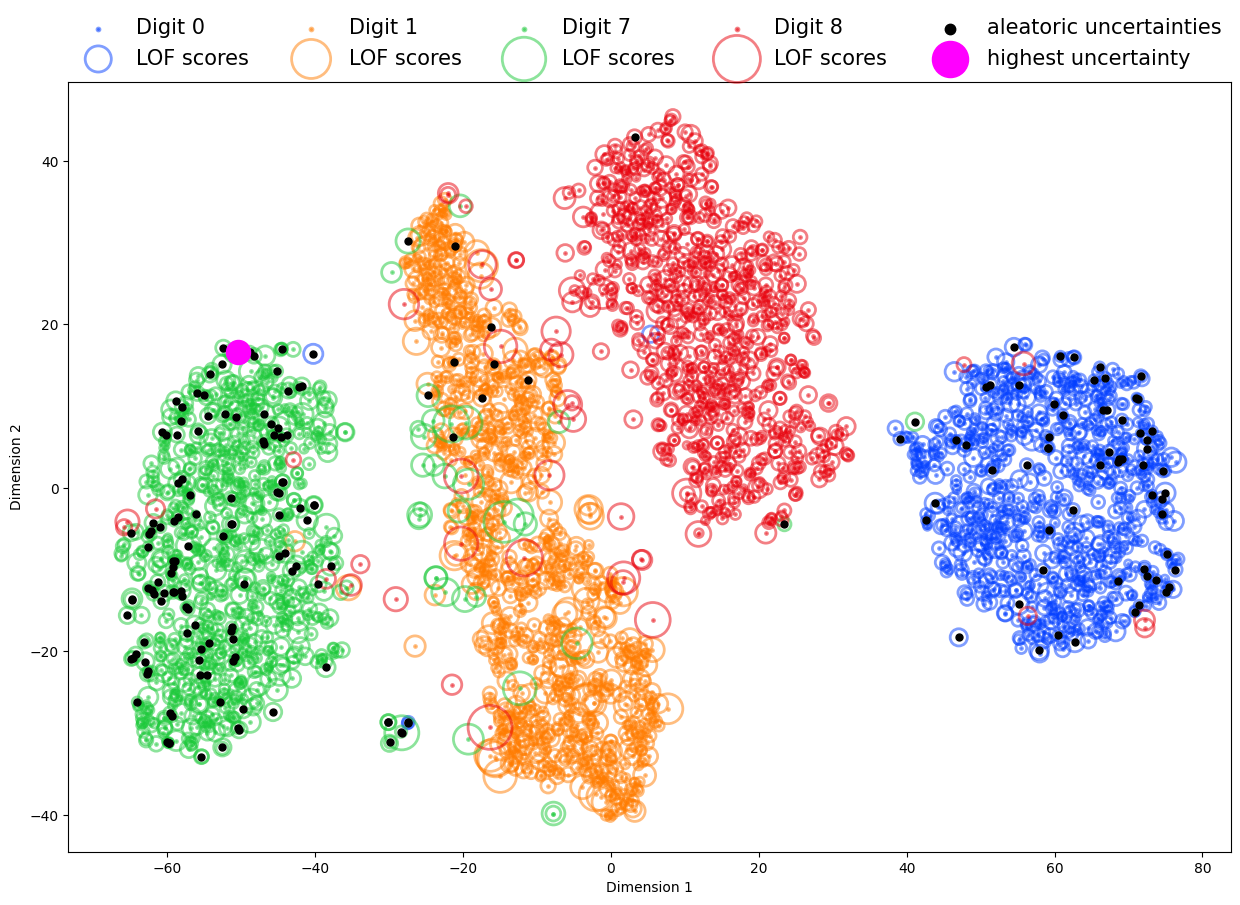

In [179]:
n = 200
uncertainty_all = sigmas_alea_cnn.argsort()[::-1]
uncertainty = uncertainty_all[:n]
selected_uncertainty = uncertainty_all[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="aleatoric uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_aleatoric.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()

highest aleatoric uncertainties using model 3

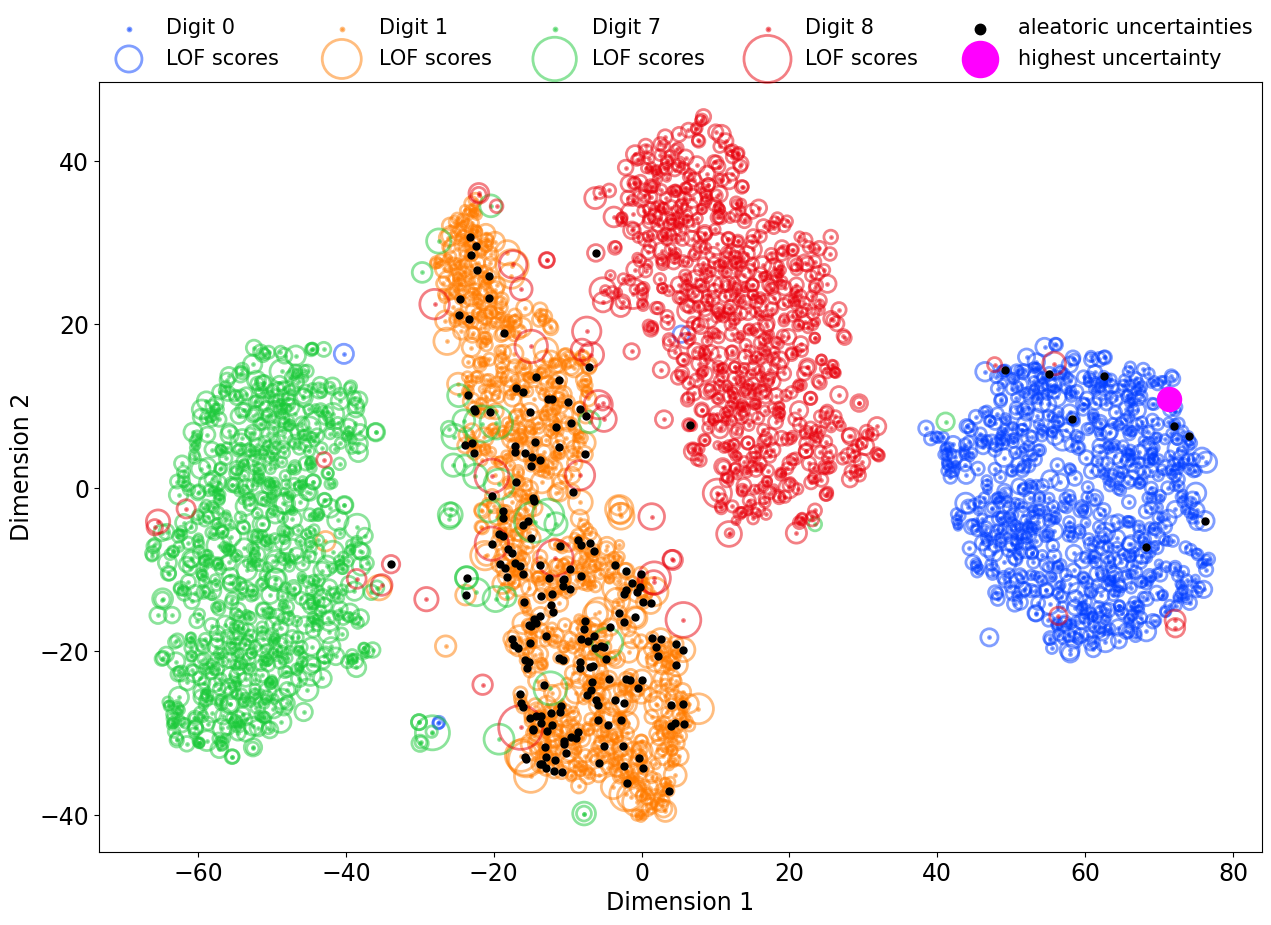

In [180]:
plt.rcParams.update({'font.size': 17})
n = 200
uncertainty_all = sigmas_alea_total_cnn.argsort()[::-1]
uncertainty = uncertainty_all[:n]
selected_uncertainty = uncertainty_all[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="aleatoric uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_aleatoric_mnist.png', 
#            transparent=True, bbox_inches='tight')

plt.show()

In [181]:
np.intersect1d(LOFidx, uncertainty)

array([1216, 1644, 1977, 2634, 2686, 2743, 3115, 3293])

lowest aleatoric uncertainties using model 2

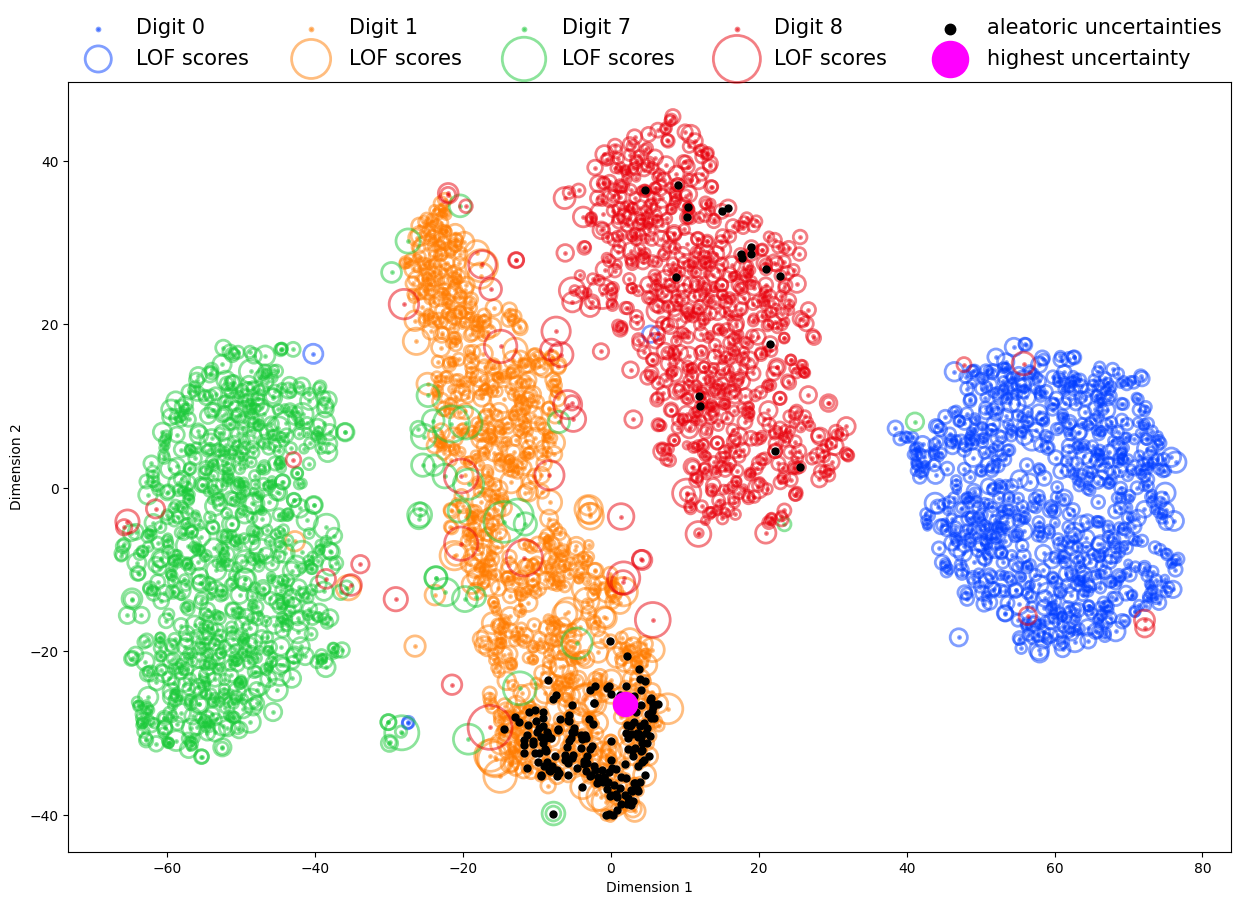

In [182]:
n = 200
uncertainty_all = sigmas_alea_cnn.argsort()
uncertainty = uncertainty_all[:n]
selected_uncertainty = uncertainty_all[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="aleatoric uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_aleatoric_lowest.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()

lowest aleatoric uncertainties using model 3

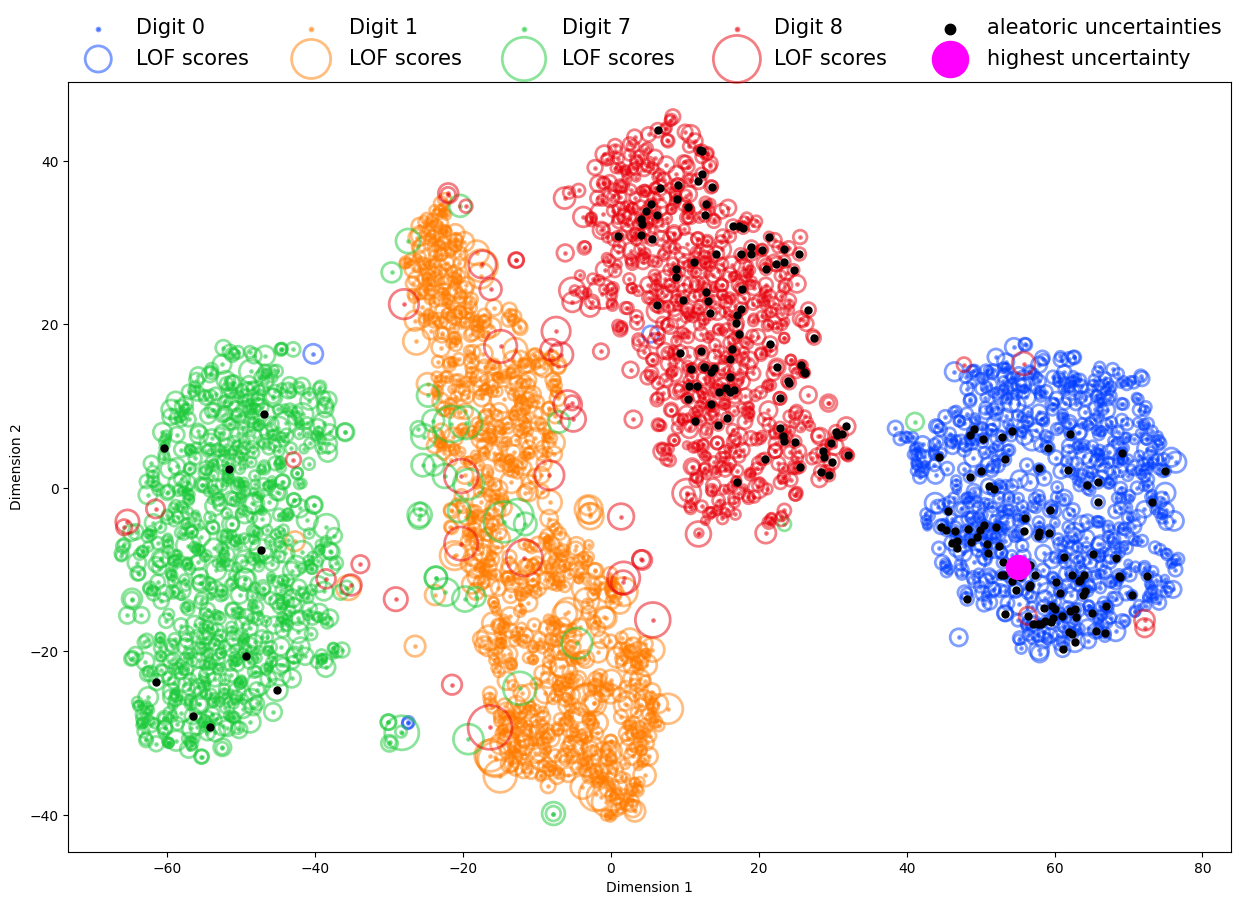

In [183]:
n = 200
uncertainty_all = sigmas_alea_total_cnn.argsort()
uncertainty = uncertainty_all[:n]
selected_uncertainty = uncertainty_all[0]

fig, ax = plt.subplots(figsize=(15,10));
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_mnist_embedded, y_mnist_test_original.to_numpy(),
                     X_scores_val_3, uncertainty, selected_uncertainty,
                     descr="aleatoric uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig(filepath + '/FINAL_plots/TSNE_aleatoric_lowest.pdf', 
#            transparent=True, bbox_inches='tight')

plt.show()

# Quality of uncertainty

code for reliablity plots and ECE from this https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py


In [184]:
import os
import numpy as np
import matplotlib.pyplot as plt


def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(np.int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return fig

In [185]:
true = y_mnist_test_original
true[true==8] = 3
true[true==7] = 2
true = np.array(true)

output_orig = orig_mnist_model_cnn.predict(X_mnist_test)
predicted_classes_orig = np.argmax(output_orig[:,:4], axis=-1)
confidence_orig = np.max(output_orig[:,:4], axis=-1)

output_mc = mc_model_cnn.predict(X_mnist_test)
predicted_classes_mc = np.argmax(output_mc[:,:4], axis=-1)
confidence_mc = np.max(output_mc[:,:4], axis=-1)

output_alea = tf.convert_to_tensor(alea_model_cnn.predict(X_mnist_test))
predicted_classes_alea = np.argmax(tf.keras.activations.softmax(output_alea[:,:4]).numpy(), 
                                axis=-1)
confidence_alea = np.max(tf.keras.activations.softmax(output_alea[:,:4]).numpy(), 
                                axis=-1)

output_total = tf.convert_to_tensor(total_mc_cnn_model.predict(X_mnist_test))
predicted_classes_total = np.argmax(tf.keras.activations.softmax(output_total[:,:4]).numpy(), 
                                axis=-1)
confidence_total = np.max(tf.keras.activations.softmax(output_total[:,:4]).numpy(), 
                                axis=-1)


original model


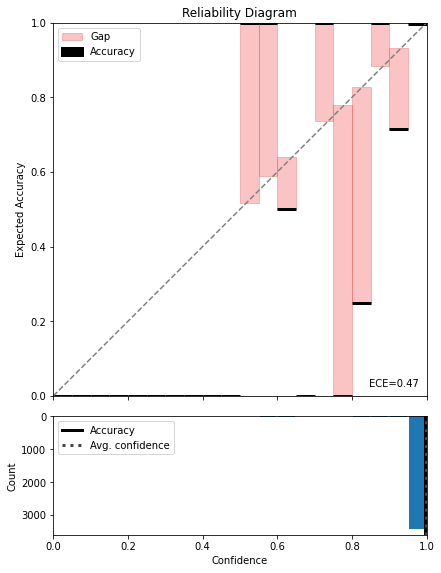

mc model


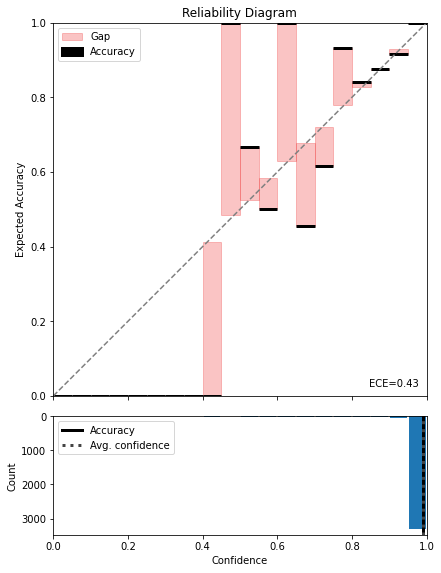

alea model


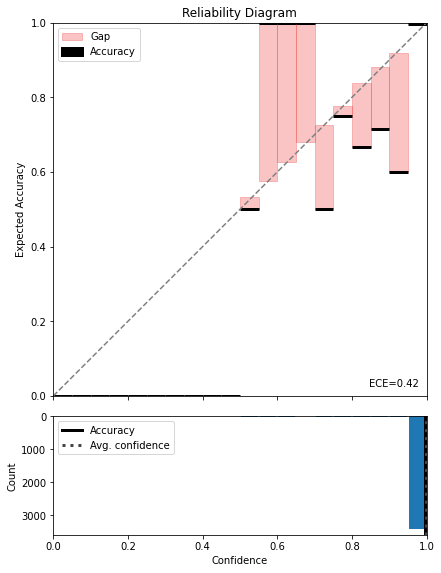

total model


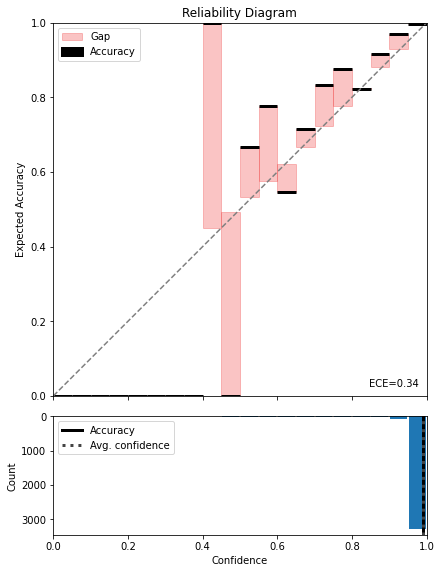

In [186]:
num_bins = 20
print("original model")
reliability_diagram(true, predicted_classes_orig, confidence_orig, num_bins=num_bins)
print("mc model")
reliability_diagram(true, predicted_classes_mc, confidence_mc, num_bins=num_bins)
print("alea model")
reliability_diagram(true, predicted_classes_alea, confidence_alea, num_bins=num_bins)
print("total model")
reliability_diagram(true, predicted_classes_total, confidence_total, num_bins=num_bins)

In [187]:
num_bins=15
res_orig = compute_calibration(true, predicted_classes_orig, confidence_orig, num_bins=num_bins)
res_mc = compute_calibration(true, predicted_classes_mc, confidence_mc, num_bins=num_bins)
res_alea = compute_calibration(true, predicted_classes_alea, confidence_alea, num_bins=num_bins)
res_total = compute_calibration(true, predicted_classes_total, confidence_total, num_bins=num_bins)

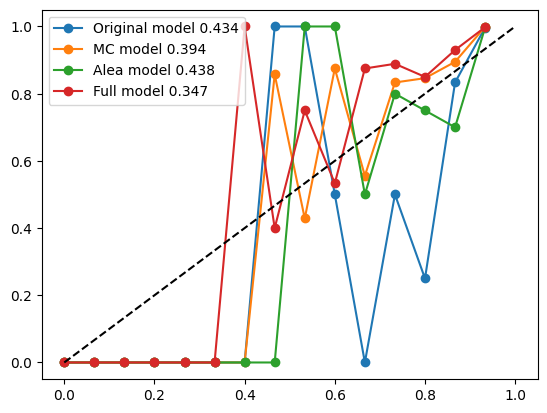

In [188]:
plt.plot(res_orig["bins"][:-1], res_orig["accuracies"], marker='o',
         label="Original model " + str(round(res_orig["expected_calibration_error"]*100,3)))
plt.plot(res_mc["bins"][:-1], res_mc["accuracies"], marker='o',
         label="MC model " + str(round(res_mc["expected_calibration_error"]*100,3)))
plt.plot(res_alea["bins"][:-1], res_alea["accuracies"], marker='o',
         label="Alea model " + str(round(res_alea["expected_calibration_error"]*100,3)))
plt.plot(res_total["bins"][:-1], res_total["accuracies"], marker='o',
         label="Full model " + str(round(res_total["expected_calibration_error"]*100,3)))
plt.plot([0,1], [0, 1], linestyle='--', color='black')
plt.legend()
plt.show()

In [189]:
from sklearn.metrics import mean_squared_error
m1 = mean_squared_error(true, predicted_classes_orig)
m2 = mean_squared_error(true, predicted_classes_mc)
m3 = mean_squared_error(true, predicted_classes_alea)
m4 = mean_squared_error(true, predicted_classes_total)

print(f"{m1:.3}, {m2:.3}, {m3:.3}, {m4:.3}")

0.0122, 0.0278, 0.0179, 0.0275


In [190]:
table4 = pd.DataFrame(dict(MNIST=['Baseline', '+ Epistemic Uncertainty',
                                 '+ Aleatoric Uncertainty', 
                                 '+ Epistemic & Aleatoric'],
                  ECE=[round(res_orig["expected_calibration_error"]*100,3),
                       round(res_mc["expected_calibration_error"]*100,3),
                       round(res_alea["expected_calibration_error"]*100,3),
                       round(res_total["expected_calibration_error"]*100,3)],
                  MSE=[round(m1,3),round(m2,3),round(m3,3),round(m4,3)]))
                  
print(table4.to_latex(index=False)) 

\begin{tabular}{lrr}
\toprule
                   MNIST &    ECE &    MSE \\
\midrule
                Baseline &  0.434 &  0.012 \\
 + Epistemic Uncertainty &  0.394 &  0.028 \\
 + Aleatoric Uncertainty &  0.438 &  0.018 \\
 + Epistemic \& Aleatoric &  0.347 &  0.027 \\
\bottomrule
\end{tabular}



In [ ]:
# !jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/Copy of MNIST.ipynb"